# Ecuador Store Sales — Global Forecasting LightGBM

This notebook aims to implement global models for store sales forecasting, diverging from traditional approaches. The main difference lies in the ability to use a single model to forecast multiple target series, improving computational efficiency. Key ideas from some referenced Kaggle notebooks include:
* [Ferdinand Berr](https://www.kaggle.com/code/ferdinandberr/darts-forecasting-deep-learning-global-models) demonstrated the use of the Darts library to simplify the process of global forecasting.
     * Additional date-related features are included to capture sales patterns.
     * 33 models, one per product family, are used to capture product-specific characteristics.
     * Zero forecasts are generated if the past 21 days are all zero sales.
* [Tom Keldenich](https://www.kaggle.com/code/kelde9/darts-ensemble-stores-sales-forecasting) built on the above ideas to further improve the forecasts.
    * Ensemble averaging is performed to average out the errors, using different numbers of lags for each model.
    * The moving averages of some variables are computed as additional covariates to smooth out the noise.
    
In this notebook, we aim to explain the rationale behind some of these different choices, and also attempt to improve the forecasts.

In [1]:
import os
                        
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, StaticCovariatesTransformer
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.metrics import rmsle
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm.notebook import tqdm_notebook

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

---

# 1. Data Preprocessing

In [2]:
# helper function to print messages
def cprint(title, *args):
    print(
        "="*len(title), title, "="*len(title),
        *args,
        sep="\n",
    )

### Loading the datasets.

We begin by loading the datasets. We then look at some of their characteristics and perform the necessary changes for visualization and modeling later.

In [3]:
PATH = "./data/"

train = pd.read_csv(os.path.join(PATH, "train.csv"), parse_dates=["date"])
test = pd.read_csv(os.path.join(PATH, "test.csv"), parse_dates=["date"])

oil = pd.read_csv(os.path.join(PATH, "oil.csv"), parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv(os.path.join(PATH, "stores.csv"))
transaction = pd.read_csv(os.path.join(PATH, "transactions.csv"), parse_dates=["date"])
holiday = pd.read_csv(os.path.join(PATH, "holidays_events.csv"), parse_dates=["date"])

### Check: There are missing gaps in the training data.

In this problem, our target series for forecasting is the `sales` column for the Ecuadorian-based grocery retailer. With 54 stores present, each having 33 types of products sold, this amounts to 1782 target series for forecasting. We can check that there are missing gaps (4 missing dates) in our target series, which we will investigate next.

In [4]:
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [5]:
cprint(
    "Basic information of data",
    f"Number of family types      : {num_family}",
    f"Number of stores            : {num_store}",
    f"Number of store-family pairs: {num_family * num_store}",
    f"Number of target series     : {num_ts}",
    "",
    f"Number of unique train dates: {num_train_date}",
    f"Train date range            : {train_len} days from {train_start} to {train_end}",
    f"Number of unique test dates : {num_test_date}",
    f"Test date range             : {test_len} days from {test_start} to {test_end}",
)

Basic information of data
Number of family types      : 33
Number of stores            : 54
Number of store-family pairs: 1782
Number of target series     : 1782

Number of unique train dates: 1684
Train date range            : 1688 days from 2013-01-01 to 2017-08-15
Number of unique test dates : 16
Test date range             : 16 days from 2017-08-16 to 2017-08-31


###  Check: The 4 missing dates fall on Christmas across the years.

It turns out that all the target series have missing dates on Christmas across the years, which suggests that the stores could be closed on this day.

In [6]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [7]:
cprint(
    "Missing gaps in time series",
    f"List incl. unique counts of data points: {unique_dp_count}",
    f"Missing dates                          : {missing_dates}",
)

Missing gaps in time series
List incl. unique counts of data points: [1684]
Missing dates                          : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


To address this problem, we fill the missing dates by reindexing our training data, and then fill the `sales` and `onpromotion` columns with 0s to indicate that there are no sales/promotions since the stores are closed.

In [8]:
# reindex training data
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

### Check: There are no oil prices on weekends.

We can check there there are no oil prices on weekends, and this is mainly due to the nature of trading markets.

In [9]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [10]:
cprint(
    "Missing oil dates",
    f"Number of missing oil dates: {num_missing_oil_dates}",
    f"Number of weekends missing : {num_wknd_missing}",
    f"Total number of weekends   : {total_num_wknd}",
)

Missing oil dates
Number of missing oil dates: 486
Number of weekends missing : 486
Total number of weekends   : 486


Because our grocery stores open on weekends as well, there is a need to estimate the missing oil prices if we are to use them in our models. For simplicity, we fill the missing values in the `oil` column using linear interpolation.

In [11]:
# reindex oil data
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

### Check: There are missing transactions due to either zero sales or missing records.

With 54 stores and 1688 training dates, we should have a total of 91152 records of transaction. However, this does not tally with the dataset given. We can easily check that the transaction data does not record days with zero sales, indicating that such days are generally not recorded. As such, for days with zero sales, we fill the `transactions` column with 0s.

After doing that, we observe that there are still missing values, suggesting that there are indeed missing data entries not due to zero sales. For simplicity, we fill the remaining missing values using linear interpolation.

In [12]:
num_zero_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(transaction.index)
missing_rec = total_rec - curr_rec - num_zero_sales

In [13]:
cprint(
    "Missing transaction records",
    f"Correct number of records: {total_rec}",
    "",
    "Breakdown...",
    f"Current number of records: {curr_rec}",
    f"Number of zero sales     : {num_zero_sales}",
    f"Number of missing records: {missing_rec}",
)

Missing transaction records
Correct number of records: 91152

Breakdown...
Current number of records: 83488
Number of zero sales     : 7546
Number of missing records: 118


In [14]:
# compute total sales for each store
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transaction = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
transaction.loc[transaction.sales.eq(0), "transactions"] = 0.
transaction = transaction.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transaction.transactions = transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

### Check: Regional holidays correspond to the state level, while local holidays correspond to the city level.

For our holiday data, we note that there are holidays on different scales (national, regional and local). Moreover, regional holidays correspond to the state level, while local holidays correspond to the city level. This can be verified by checking the `locale_name` column, as well as the `city` and `state` columns in the store data. 

For national holidays, the `locale_name` always states the country, Ecuador. On the other hand, the values of `locale_name` can also be found in the `state` column for regional holidays. The same goes for local holidays with the `city` column. Because of this, we find out that not all cities have local holidays, and not all states have regional holidays.

In [15]:
national_locale_name = sorted(holiday[holiday.locale.eq("National")].locale_name.unique().tolist())
regional_locale_name = sorted(holiday[holiday.locale.eq("Regional")].locale_name.unique().tolist())
local_locale_name = sorted(holiday[holiday.locale.eq("Local")].locale_name.unique().tolist())

In [16]:
cprint(
    "List of locale names for each holiday",
    "Locale names for national holidays:",
    national_locale_name,
    "",
    "Locale names for regional holidays:",
    regional_locale_name,
    "",
    "Locale names for local holidays:",
    local_locale_name,
)

List of locale names for each holiday
Locale names for national holidays:
['Ecuador']

Locale names for regional holidays:
['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']

Locale names for local holidays:
['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


### Check: There are many holidays of a similar nature, which can be grouped together to simplify modeling.

In the holiday data, some days surrounding the actual holidays are also labeled as holidays. An example is shown below for Christmas (Navidad) 2012, where terms like '-4' and '+1' indicate the number of days before and after Christmas. We can check that in general, these surrounding days are labeled as 'Additional' in the `type` column. In addition, since Christmas 2012 falls on a Tuesday, 24 December 2012 is declared as a bridge holiday to make a long weekend. We can group such holidays together for standardization.

In [17]:
holiday[(holiday.description.str.contains("Navidad"))&(holiday.date.dt.year.eq(2012))]

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False


It turns out that there are other examples, such as the Independence Day for the different cities. For simplicity, we assume that such holidays should have similar impacts on the store sales. We assign the same labels for such holidays by removing extra words like bridge (puente) and the city/state names from the `description` column. The function to process the column is given below.

In [18]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(store.city.str.lower()) | set(store.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [19]:
holiday.description = holiday.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""), 
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


We further process the holiday data by removing holidays which are transferred. This can be checked using the `transferred` column. Since the holidays are not celebrated during the official date and are more like normal days, we exclude them. 

We then separate them into national/regional/local holidays, and Saturdays that are designated as work days. Prefixes `nat_` / `loc_` are set for national/local holidays to better differentiate them during visualization later. For regional holidays, it turns out that we only have `provincialization`, so it is being labeled as such. An example is shown below, where the national holidays are being encoded as dummy variables. The same applies for the other holidays.

In [20]:
# remove transferred holidays
holiday['transferred'] = holiday['transferred'].astype(bool)

#########################################
### Saturdays designated as work days ###
#########################################
work_days = holiday[holiday.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
holiday = holiday[holiday.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = holiday[holiday.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = holiday[holiday.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = holiday[holiday.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-09,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0


---

# 2. Data Exploration

After data preprocessing, we can now analyze our data and discover patterns using visualizations. Before we do that, we reshape our data from the long form to the wide form, where each column corresponds to one time series. Either forms can be easier to work with in different situations. An example is shown below for our target series, where the index is the time dimension represented by `date` and the columns are the `sales` for each store-family pair.

In [21]:
sales_ts = pd.pivot_table(train, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transaction, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(train, values="onpromotion", index="date", columns=["store_nbr", "family"])

sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

For visualization purposes, there is a need to scale our data if we want to look at the average value of the `sales` column. This helps to balance the impact across all store-family pairs on the average value. The same applies for the `transactions` and `onpromotion` values, but we will scale them only when needed later.

We also convert back the scaled sales data to the long form and add the holiday columns to analyze the holiday effects later. An additional column `no_holiday` is computed to indicate days without any holidays. This is important when we are comparing the store sales between holiday and non-holiday periods.

In [22]:
# scale target series
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,
).reset_index().merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,0.105263,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-01-03,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013-01-04,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2013-01-05,1,AUTOMOTIVE,0.263158,Quito,Pichincha,D,13,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Finding: In general, the number of zero sales is decreasing over time. Besides Christmas, there are also large numbers of zero sales on New Year's Day.

We start off by counting the number of target series with zero sales for each day. The counts of zero sales has a general **downward trend**, suggesting that periods with no sales are becoming less frequent and that the stores are generating positive sales consistently. This could be due to changes in some covariates that have a **temporal relationship** with the sales numbers, which we will investigate later.

Besides Christmas, we also have large counts of zero sales on New Year's Day across the years. Similarly, many stores could be closed on this occasion, which we should take note of in our models later. Interestingly, there are great fluctations in the count of zero sales between 2014 and 2015.

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51029/2801391214.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  high_zero_counts = zero_count_filtered[zero_count_filtered.date.isin(high_zero_dates)].zero_sales_ct.tolist()


Dates with zero sales
Dates (excl. Christmas) with zero sales: ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']
Corresponding counts of zero sales     : [1765, 1732, 1759, 1753, 1754]
Total number of target series          : 1782


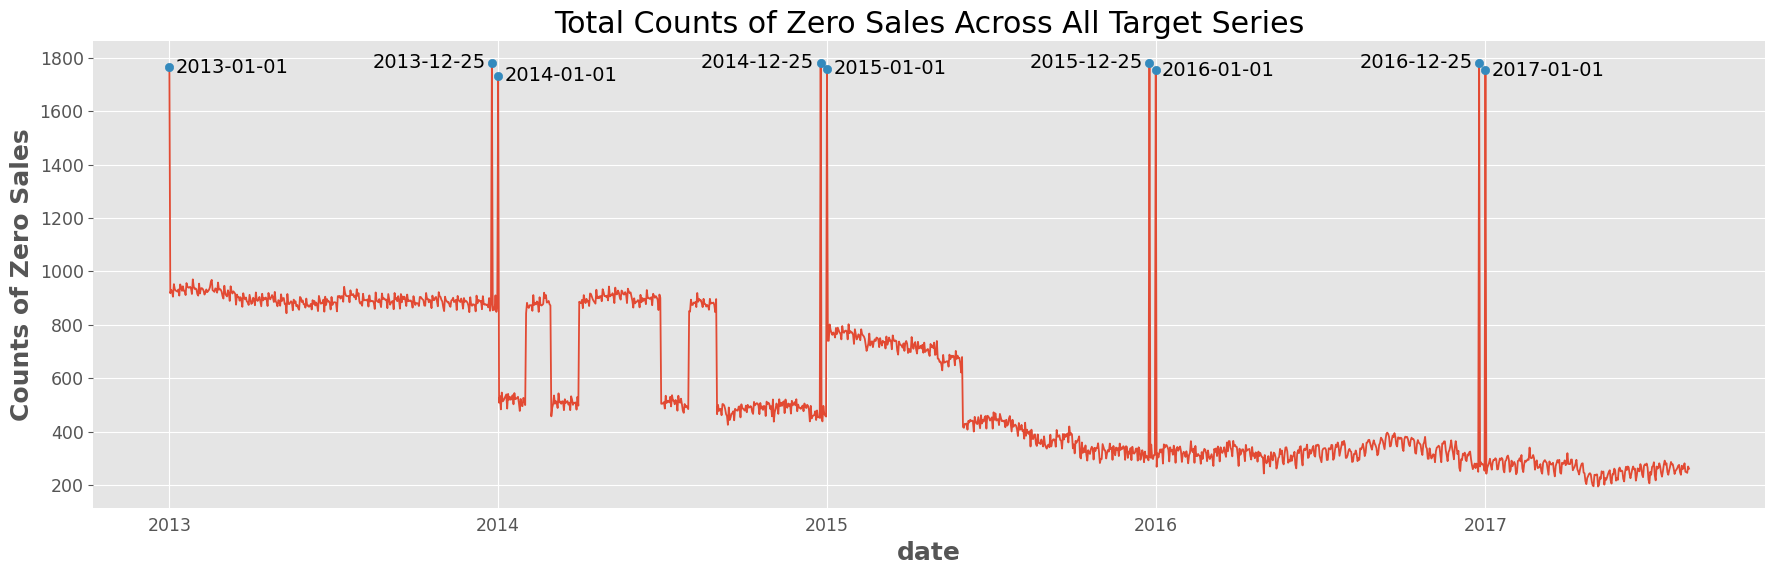

In [23]:
def plot_zero_count_ts():
    zero_count_ts = (sales_ts.eq(0)).sum(axis=1).to_frame("zero_sales_ct").reset_index()
    zero_count_filtered = zero_count_ts[zero_count_ts.zero_sales_ct.gt(1500)].reset_index(drop=True)
    high_zero_dates = zero_count_filtered.date.dt.strftime("%Y-%m-%d")
    high_zero_dates = [d for d in high_zero_dates if not d.endswith("12-25")]
    high_zero_counts = zero_count_filtered[zero_count_filtered.date.isin(high_zero_dates)].zero_sales_ct.tolist()
    
    cprint(
        "Dates with zero sales",
        f"Dates (excl. Christmas) with zero sales: {high_zero_dates}",
        f"Corresponding counts of zero sales     : {high_zero_counts}",
        f"Total number of target series          : {num_ts}",
    )
    
    plt.figure(figsize=(18, 6))
    
    sns.lineplot(data=zero_count_ts, x="date", y="zero_sales_ct")
    sns.scatterplot(
        data=zero_count_filtered, x="date", y="zero_sales_ct",
        color=COLORS[1],
        edgecolor=COLORS[1],
        zorder=2,
    )
    for j in range(len(zero_count_filtered.index)):
        ha = "left" if j%2==0 else "right"
        offset = pd.Timedelta(7, "d") if ha=="left" else pd.Timedelta(-7, "d")
        plt.text(
            x=zero_count_filtered.date[j]+offset, y=zero_count_filtered.zero_sales_ct[j], 
            s=zero_count_filtered.date[j].strftime("%Y-%m-%d"),
            ha=ha,
            va="center",
            size=14,
        )
    plt.ylabel("Counts of Zero Sales")
    plt.title("Total Counts of Zero Sales Across All Target Series")
    plt.tight_layout()
    plt.show()

plot_zero_count_ts()

### Finding: There are some target series with all values equal to zero.

Our training data has 53 target series with all values equal to zero. This could be due to poor sales performance or product unavailability. What is interesting here is that all stores have about 0 to 3 zero constant target series. If we consider this by the product family, books have the most number of zero constant target series. It appears that the **problem of zero sales could be due to the type of product** being sold.

Constant target series
Number of constant target series: 53
List of unique constant values  : [0.0]


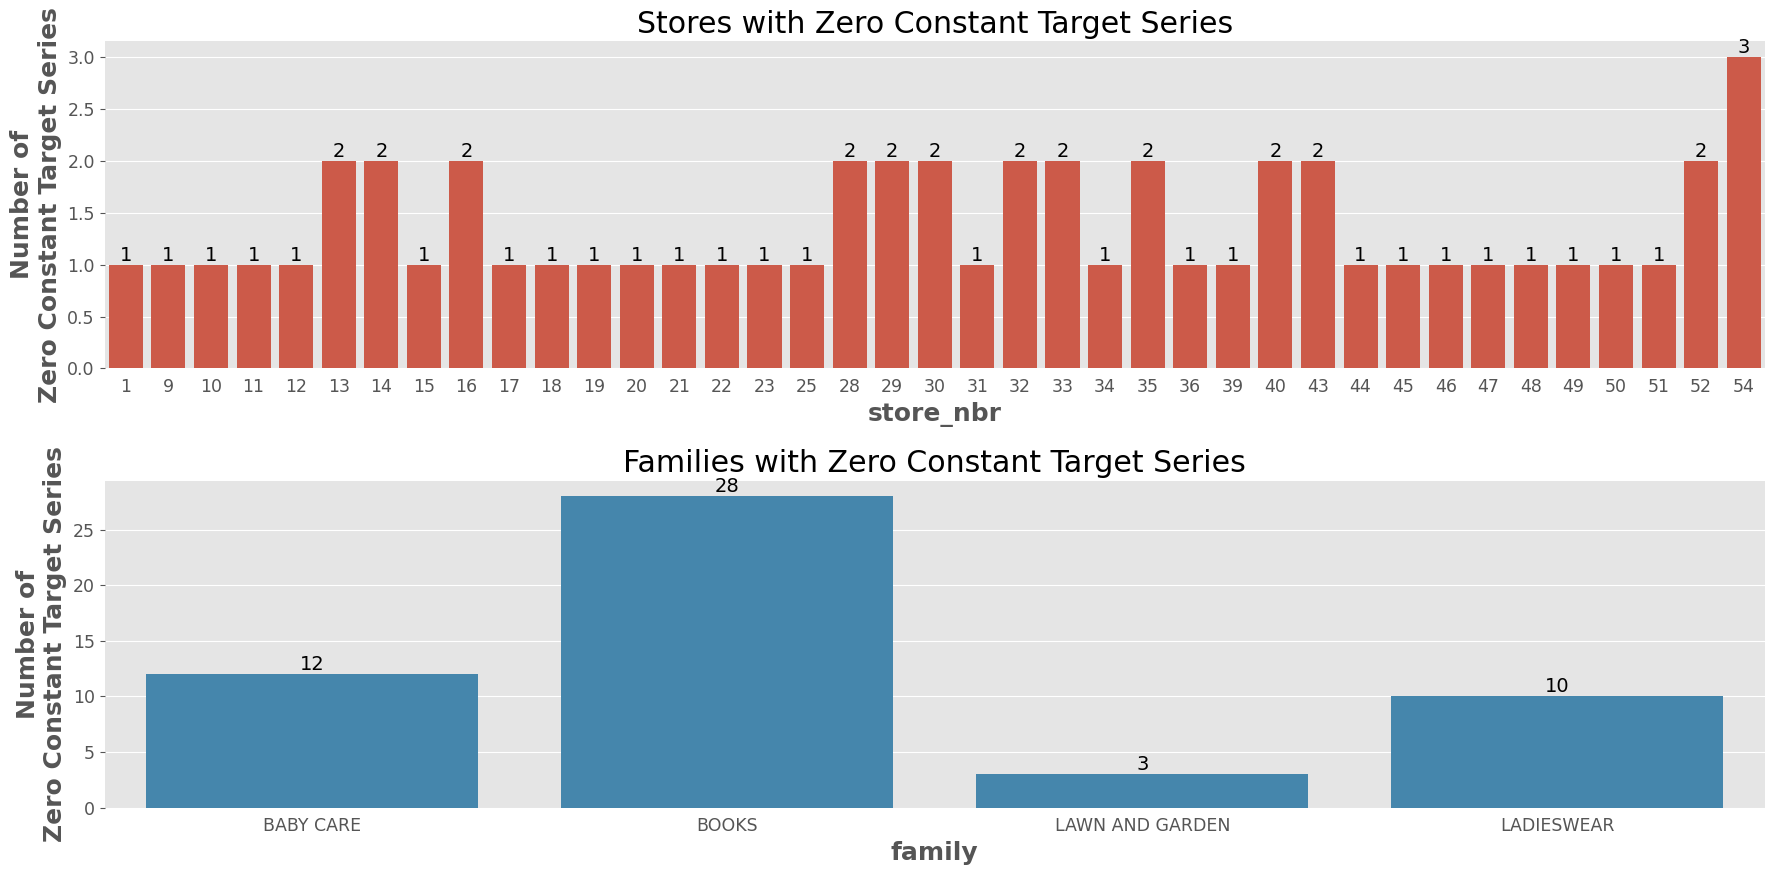

In [24]:
def plot_constant_ts_distribution():
    const_ts = sales_ts.iloc[:, (sales_ts.std()==0).tolist()]
    const_ts_labels = const_ts.columns.to_frame().reset_index(drop=True)
    
    cprint(
        "Constant target series",
        f"Number of constant target series: {len(const_ts.columns)}",
        f"List of unique constant values  : {const_ts.iloc[0].unique().tolist()}",
    )
    
    fig = plt.figure(figsize=(18, 9))

    ax0 = sns.countplot(
        data=const_ts_labels, x="store_nbr",
        color=COLORS[0],
        ax=fig.add_subplot(211),
    )
    ax0.bar_label(ax0.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Stores with Zero Constant Target Series")

    ax1 = sns.countplot(
        data=const_ts_labels, x="family",
        color=COLORS[1],
        ax=fig.add_subplot(212),
    )
    ax1.bar_label(ax1.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Families with Zero Constant Target Series")

    plt.tight_layout()
    plt.show()
    
plot_constant_ts_distribution()

### Finding: There are many target series with leading zeros.

We look at some possible patterns of zero store sales. The zero constant target series are removed to get a better picture of the remaining target series. It turns out that we have many target series with leading zeros, with some series consisting of thousands of leading zeros. This suggests the possibility of product unavailability, or simply poor sales performance at the start.

We note that the distribution of leading zeros is **fairly consistent** across the stores, with only a few stores having the boxplots lying above the rest. Examples are store numbers 52, 53. This could mean that some stores are more recently open, so there are no sales at the start of the target series. 

On the other hand, the distribution of leading zeros **varies** across the families of products. This suggests that the **problem of leading zeros could be related to the type of products**, like the target series for books all having thousands of leading zeros. This supports the previous finding above.

Time series with leading zeros (excluding zero constant target series)
Total number of time series                : 1729
Number of time series with >1 leading zeros: 865


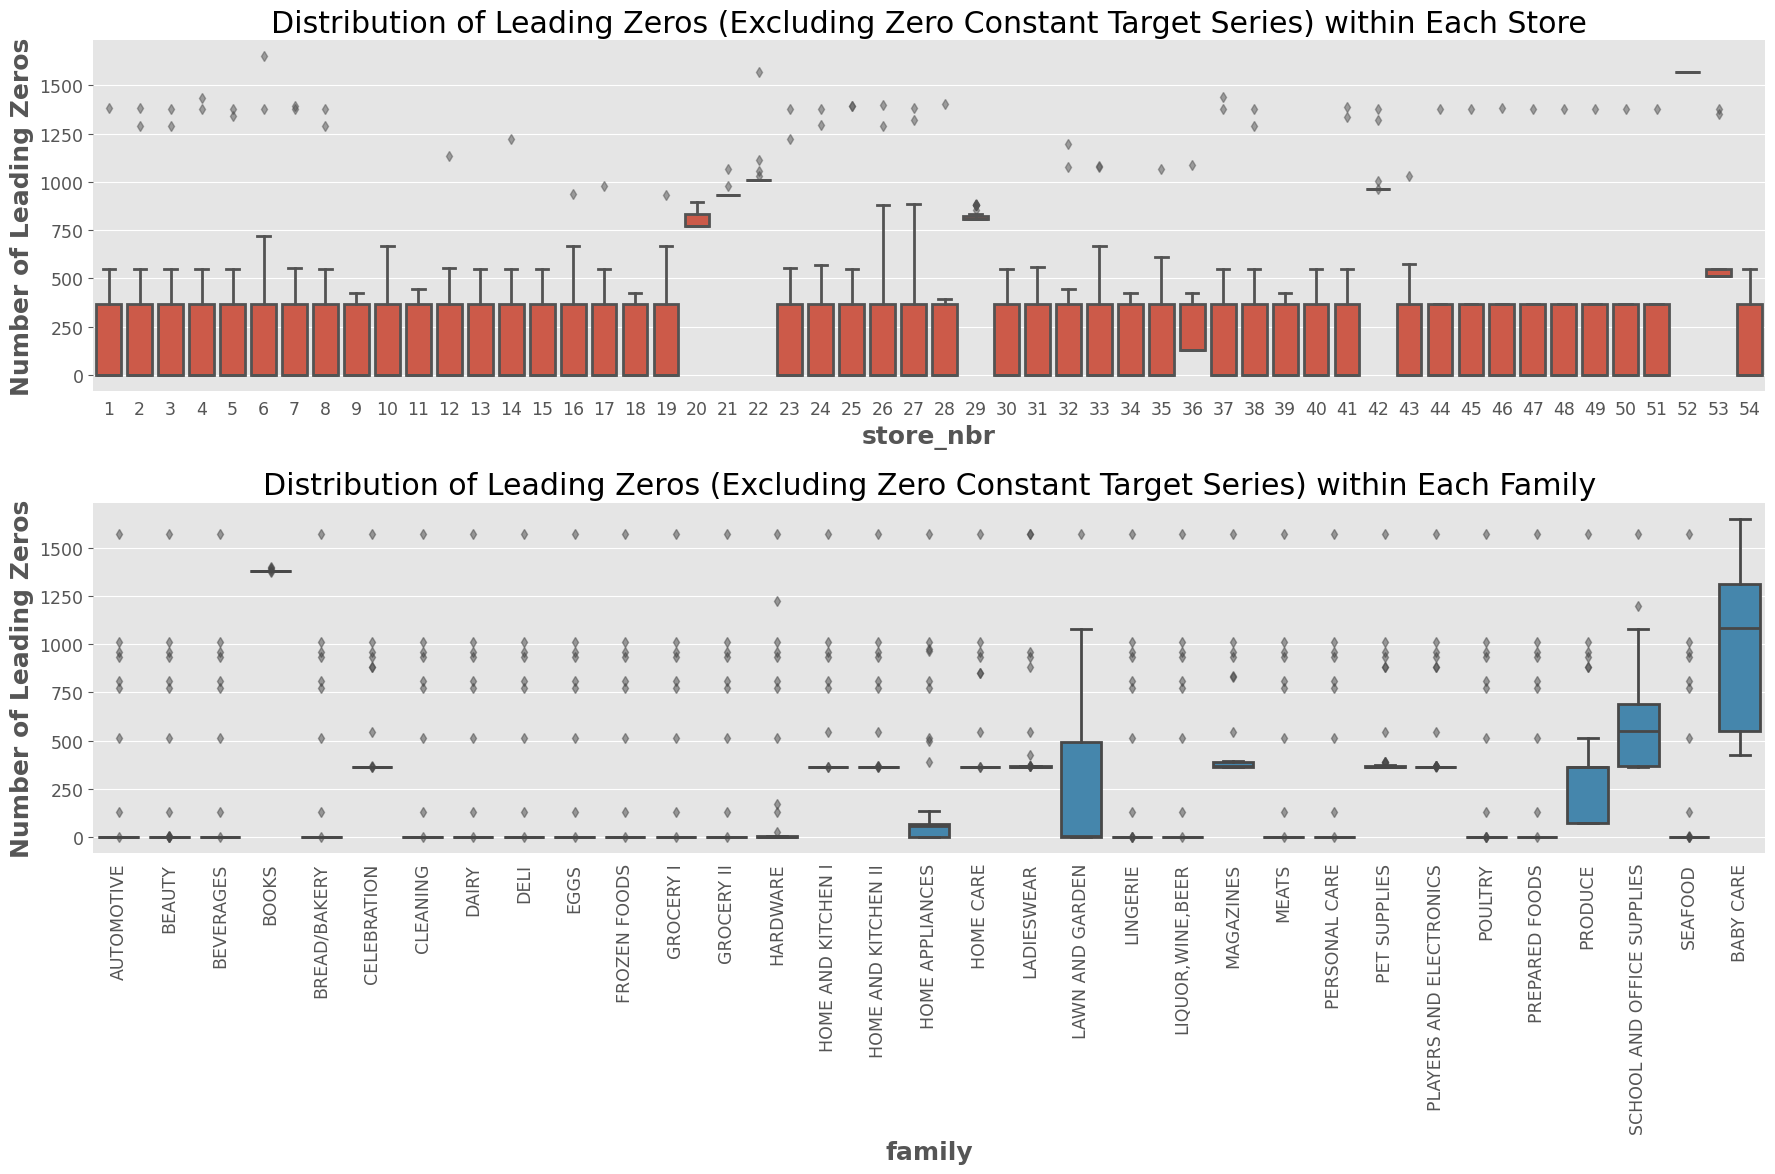

In [25]:
def count_leading_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return nonzero_idx[0]
    else:
        return len(x)

def plot_leading_zeros_distribution():
    leading_zeros = sales_ts.apply(count_leading_zeros).to_frame("num_leading_zeros").reset_index()
    leading_zeros = leading_zeros[leading_zeros.num_leading_zeros.lt(train_len)]
    
    cprint(
        "Time series with leading zeros (excluding zero constant target series)",
        f"Total number of time series                : {len(leading_zeros.index)}",
        f"Number of time series with >1 leading zeros: {leading_zeros.num_leading_zeros.gt(1).sum()}",
    )
    
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }
    
    fig = plt.figure(figsize=(18, 12))
    
    ax0 = sns.boxplot(
        data=leading_zeros, x="store_nbr", y="num_leading_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Number of Leading Zeros")
    plt.title("Distribution of Leading Zeros (Excluding Zero Constant Target Series) within Each Store")

    ax1 = sns.boxplot(
        data=leading_zeros, x="family", y="num_leading_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Number of Leading Zeros")
    plt.title("Distribution of Leading Zeros (Excluding Zero Constant Target Series) within Each Family")

    plt.tight_layout()
    plt.show()

plot_leading_zeros_distribution()

### Finding: There are few target series with trailing zeros.

We can also examine the number of trailing zeros at the end of the target series. Similarly, we remove the zero constant target series here. There are not as many target series with trailing zeros, suggesting **consistent** sales across the years.

However, the presence of target series having hundreds of trailing zeros could be due to poor sales performance or that the product is no longer available towards the end. An example would be lawn and garden. In this case, **generating zero forecasts** for such target series would be a reasonable approach.

Target series with trailing zeros (excluding zero constant target series)
Total number of time series                : 1729
Number of target series with trailing zeros: 208


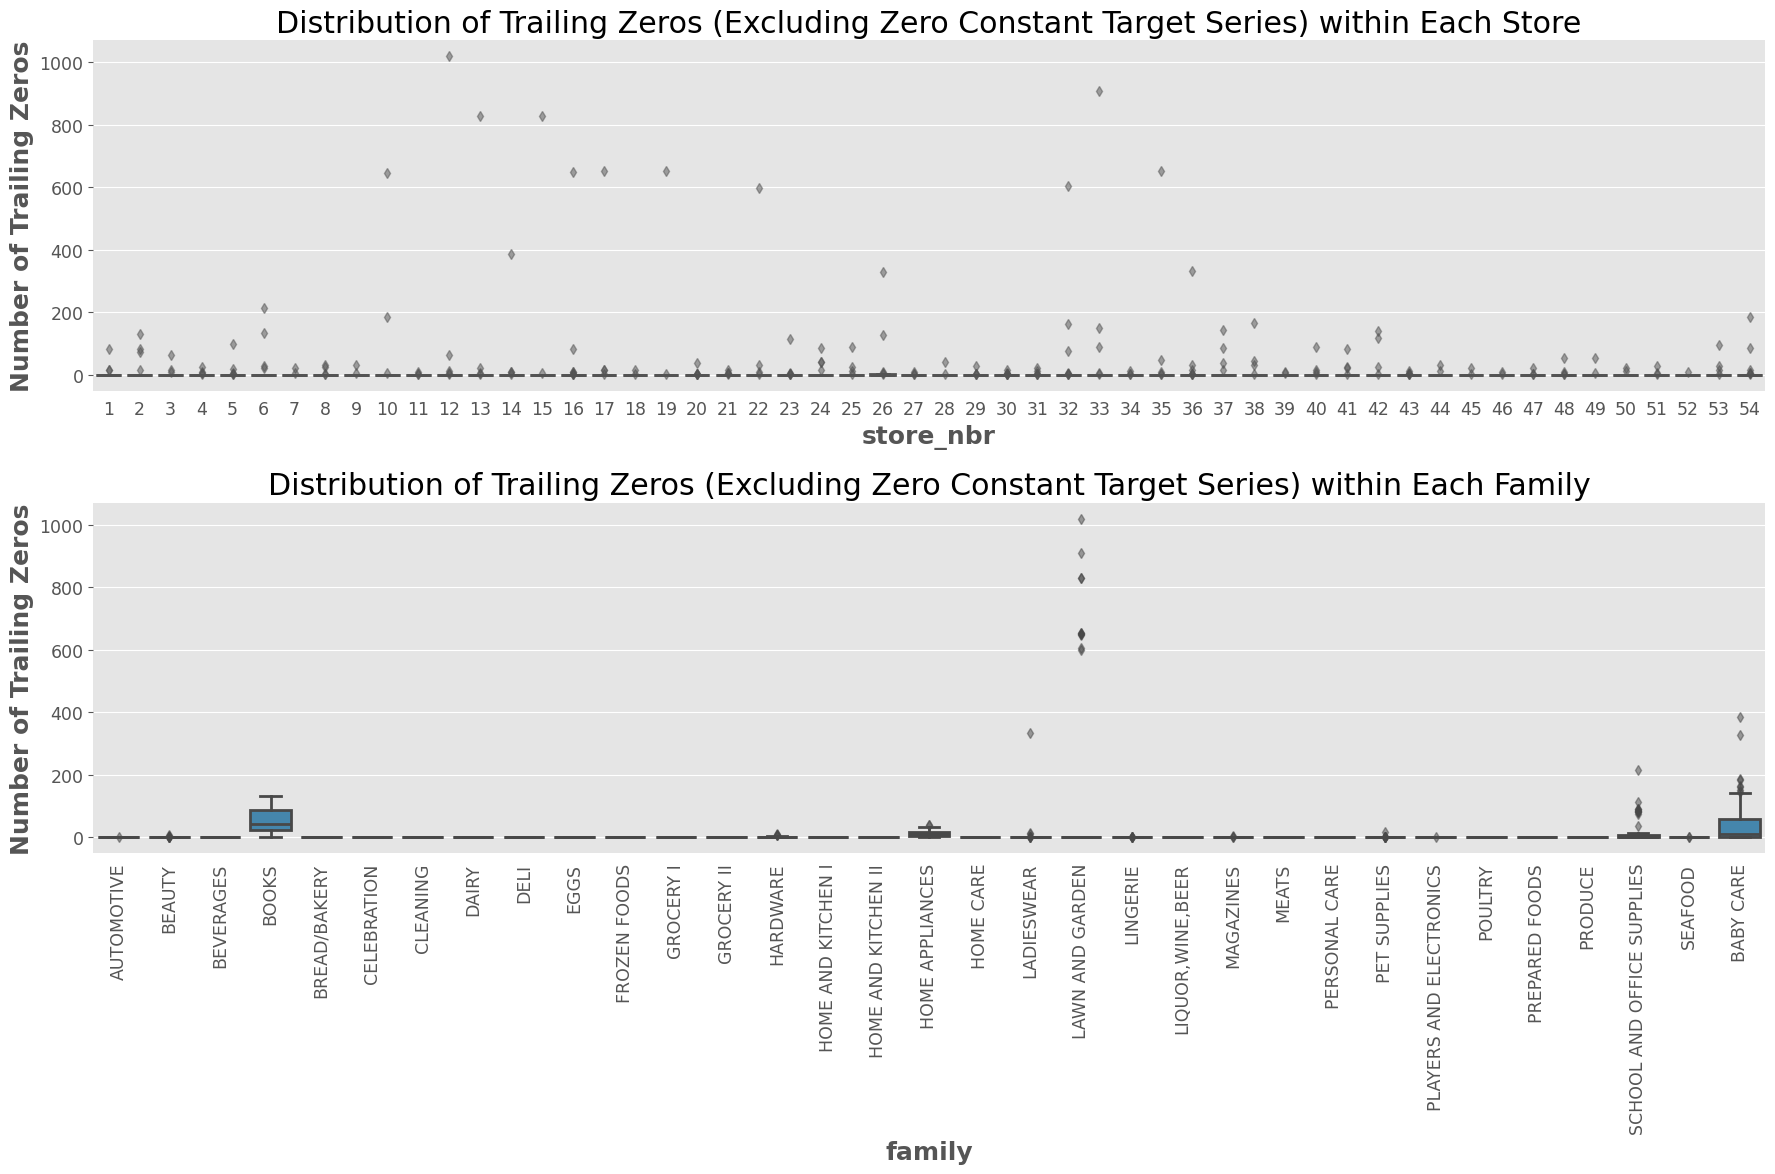

In [26]:
def count_trailing_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return len(x) - nonzero_idx[-1] - 1
    else:
        return len(x)

def plot_trailing_zeros_distribution():
    trailing_zeros = sales_ts.apply(count_trailing_zeros).to_frame("num_trailing_zeros").reset_index()
    trailing_zeros = trailing_zeros[trailing_zeros.num_trailing_zeros.lt(train_len)]
    
    cprint(
        "Target series with trailing zeros (excluding zero constant target series)",
        f"Total number of time series                : {len(trailing_zeros.index)}",
        f"Number of target series with trailing zeros: {trailing_zeros.num_trailing_zeros.gt(0).sum()}",
    )
    
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }
    
    fig = plt.figure(figsize=(18, 12))
    
    ax0 = sns.boxplot(
        data=trailing_zeros, x="store_nbr", y="num_trailing_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Number of Trailing Zeros")
    plt.title("Distribution of Trailing Zeros (Excluding Zero Constant Target Series) within Each Store")

    ax1 = sns.boxplot(
        data=trailing_zeros, x="family", y="num_trailing_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Number of Trailing Zeros")
    plt.title("Distribution of Trailing Zeros (Excluding Zero Constant Target Series) within Each Family")

    plt.tight_layout()
    plt.show()

plot_trailing_zeros_distribution()

### Finding: The average sales is correlated with oil prices, promotions, and store transactions.

After analyzing the target series, we look at possible covariates to help improve our models. The `transactions` column is considered as a past covariate because only its past values are known at the point of forecasting. To forecast the sales for tomorrow, we only know the values of the transactions that happened up to today.

On the other hand, the `oil` and `onpromotion` columns are future covariates because their current (and possibly future) values are known at the point of forecasting. To forecast the sales for tomorrow, we have the values of oil prices and promotion values for tomorrow. This makes sense because setting the promotion values is usually done in advance to promote future store sales. It is unusual for us to know the oil prices in advance, but since we are given the data, one possible explanation is that we are using estimates of the oil prices.

As mentioned previously, the `transactions` and `onpromotion` columns will be scaled before computing the average values. The average sales are computed by taking the average across all 1782 target series. From the plots below, we observe that:
* Oil prices are **negatively** correlated with average sales. With Ecuador being an oil-dependent country, larger oil prices could have inflationary effects, resulting in smaller store sales.
* Promotion values are **positively** correlated with average sales. This is straightfoward because with more ongoing promotions, this attracts human traffic and thus encourages greater sales. Another interesting observation is that there are **zero promotion values up to early 2014**.
* Store transactions are **positively** correlated with average sales. The grocery stores consist of many product families which complement each other, like poultry, produce, and other food products. It makes sense that if a person buys some meat, that person is also more likely to buy vegetables as a complement for a balanced diet. As such, the sales for one product could affect another, so stores with larger transactions should also have larger sales for each product family in general.
* The average sales has a general **upward trend**, with sharp declines during Christmas and New Year as explained earlier. With smaller oil prices, greater promotion values and larger store transactions, these seem to support the correlation with average sales as explained above.

Covariates: oil, onpromotion, transactions
Past covariates  : transactions
Future covariates: oil, onpromotion


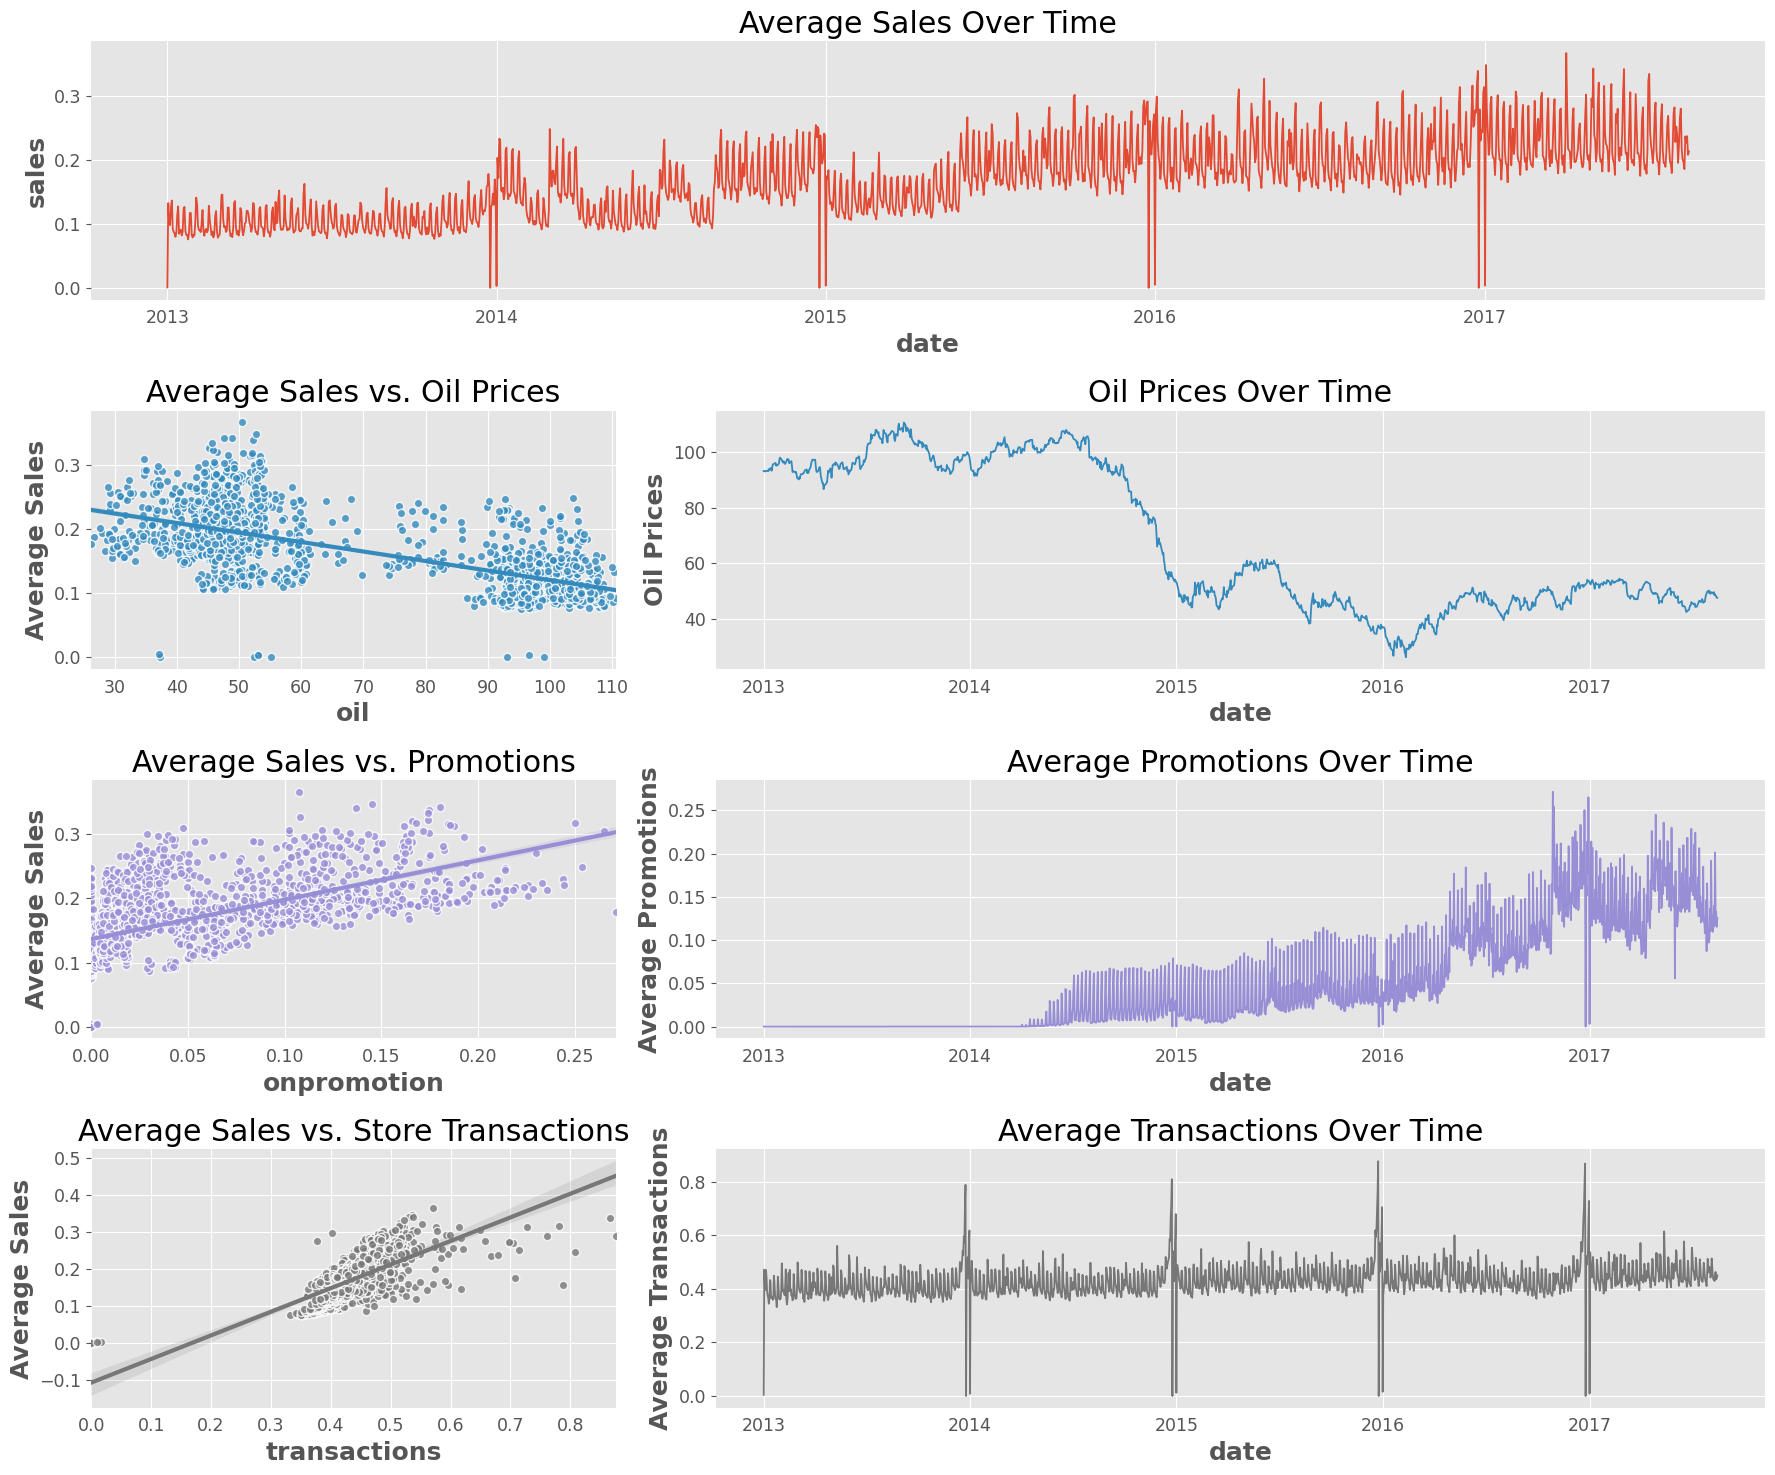

In [27]:
def plot_sales_correlation():   
    tr_ts_scaled = tr_ts.copy()
    tr_ts_scaled[tr_ts_scaled.columns] = scaler.fit_transform(tr_ts_scaled)

    promo_ts_scaled = promo_ts.copy()
    promo_ts_scaled[promo_ts_scaled.columns] = scaler.fit_transform(promo_ts_scaled)
    
    mean_sales_ts_scaled = sales_ts_scaled.mean(axis=1).to_frame("sales").reset_index()
    mean_promo_ts_scaled = promo_ts_scaled.mean(axis=1).to_frame("onpromotion").reset_index()
    mean_tr_ts_scaled = tr_ts_scaled.mean(axis=1).to_frame("transactions").reset_index()
    
    cprint( 
        "Covariates: oil, onpromotion, transactions",
        "Past covariates  : transactions",
        "Future covariates: oil, onpromotion",
    )

    plot_kwargs = {
        "scatter_kws": {"edgecolor": "white"},
        "line_kws": {"lw": 3},
    }
    
    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(4, 2, width_ratios=(1, 2))
    
    sns.lineplot(
        data=mean_sales_ts_scaled,
        x="date",
        y="sales",
        ax=fig.add_subplot(gs[0, :]),
    )
    plt.title("Average Sales Over Time")
    
    sns.regplot(
        x=oil.oil.iloc[:train_len], y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[1, 0]),
        color=COLORS[1],
        **plot_kwargs,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Oil Prices")
    
    sns.lineplot(
        data=oil.iloc[:train_len, :], x="date", y="oil",
        ax=fig.add_subplot(gs[1, 1]),
        color=COLORS[1],
    )
    plt.ylabel("Oil Prices")
    plt.title("Oil Prices Over Time")

    sns.regplot(
        x=mean_promo_ts_scaled.onpromotion, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[2, 0]),
        color=COLORS[2],
        **plot_kwargs,
    )
    plt.xlabel("onpromotion")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Promotions")

    sns.lineplot(
        data=mean_promo_ts_scaled, x="date", y="onpromotion",
        ax=fig.add_subplot(gs[2, 1]),
        color=COLORS[2],
    )
    plt.ylabel("Average Promotions")
    plt.title("Average Promotions Over Time")
    
    sns.regplot(
        x=mean_tr_ts_scaled.transactions, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[3, 0]),
        color=COLORS[3],
        **plot_kwargs,
    )
    plt.xlabel("transactions")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Store Transactions")
    
    sns.lineplot(
        data=mean_tr_ts_scaled, x="date", y="transactions",
        ax=fig.add_subplot(gs[3, 1]),
        color=COLORS[3],
    )
    plt.ylabel("Average Transactions")
    plt.title("Average Transactions Over Time")

    plt.tight_layout()
    plt.show()
    
plot_sales_correlation()

### Finding: Most states only have stores in one city. For states with stores in multiple cities, the number of stores is generally dominated by one city.

Besides past and future covariates, we also have static covariates which are constant over time. The `city` and `state` columns from the store data are considered static covariates because they represent unique characteristics of the store and do not change over time. Other examples are `store_nbr` and `family`, which we have looked at earlier.

The stacked bar chart below denotes the number of stores within each state, and the units are labeled by the corresponding store numbers. They are color-coded by each unique city within the state. Using Manabi as an example, store number 54 belongs to one city while store numbers 52, 53 belong to another city.

We can see that most states only have one color, meaning that there are stores in only one city within each state. Some states like Guayas and Pichincha have stores in multiple cities, but the stores are dominated by one city. In other words, there **may not be a noticeable difference between the city-level and state-level impacts** on store sales, but this requires some experimentation later.

Static covariates: city, state
Number of unique cities                      : 22
Number of unique states                      : 16
Number of states with stores in only one city: 12


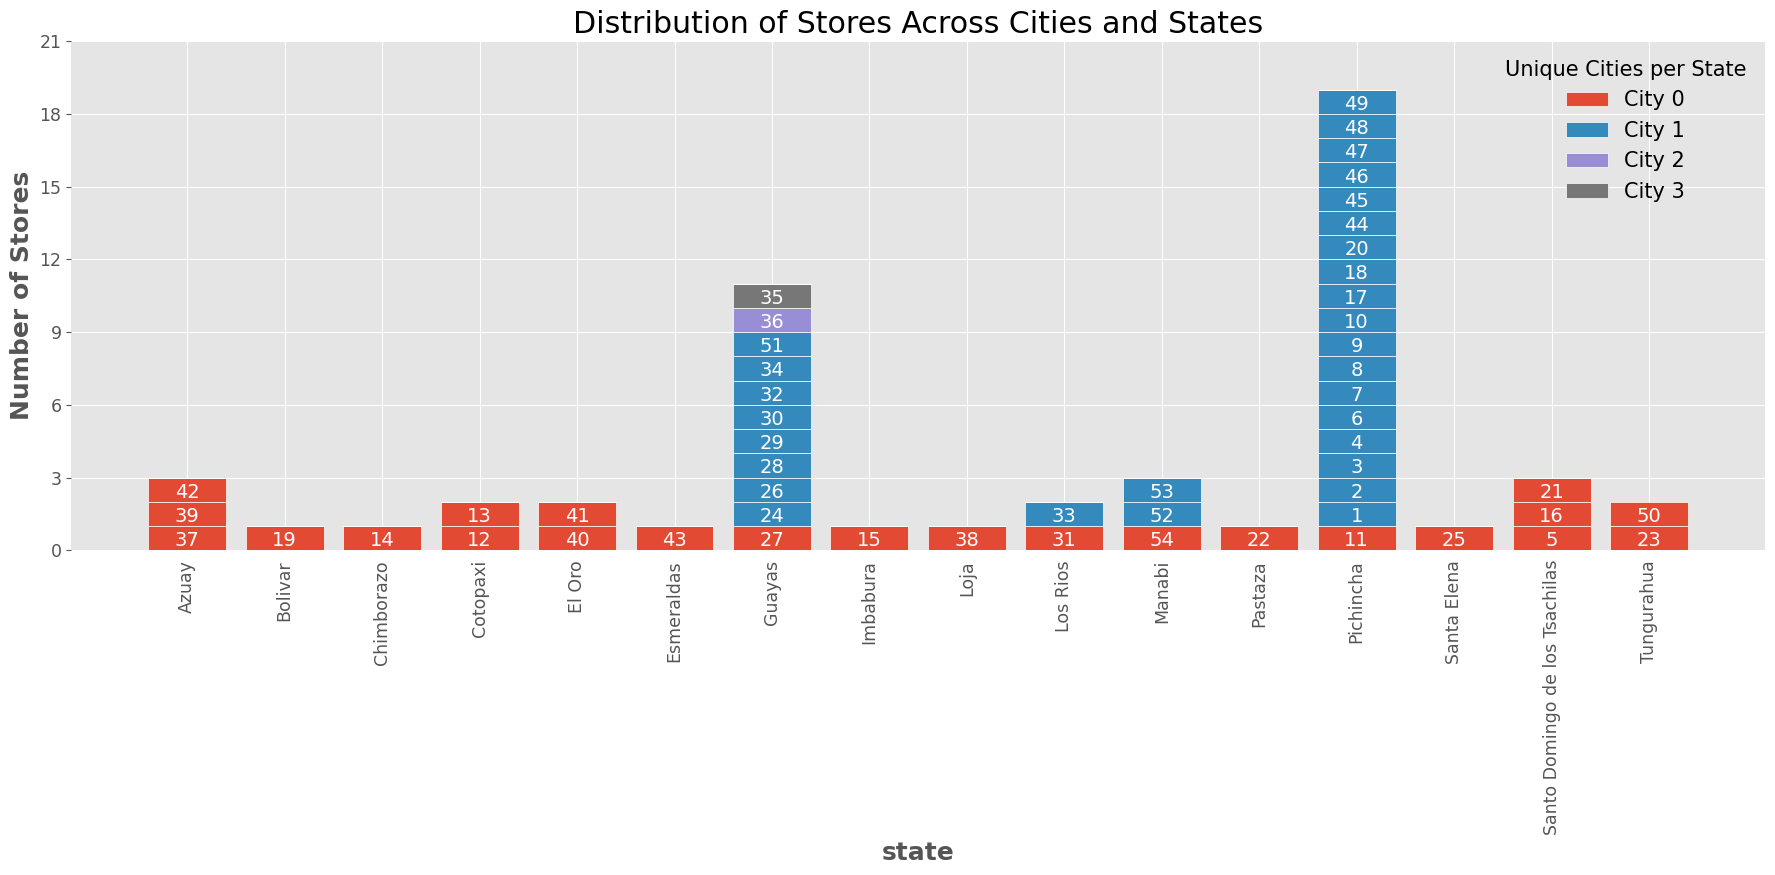

In [28]:
def plot_city_state_distribution(store):
    cprint(
        "Static covariates: city, state",
        f"Number of unique cities                      : {store.city.nunique()}",
        f"Number of unique states                      : {store.state.nunique()}",
        f"Number of states with stores in only one city: {(store.groupby('state').city.nunique().eq(1)).sum()}",
    )
    
    store = store.copy().sort_values(["state", "city", "store_nbr"])
    state_list = store.state.unique()
    bar_bottom = np.zeros(len(state_list))
    counter = {}

    fig = plt.figure(figsize=(18, 9))
    
    for num in store.store_nbr.unique():
        curr_state, curr_city = store.loc[store.store_nbr.eq(num), ["state", "city"]].values[0]
        if curr_state not in counter:
            counter[curr_state] = []
        if curr_city not in counter[curr_state]:
            counter[curr_state].append(curr_city)
        state_ind = (state_list==curr_state).astype(int)
        plt.bar(
            x=state_list, height=state_ind,
            bottom=bar_bottom,
            color=COLORS[len(counter[curr_state])-1],
            edgecolor="white",
            label=f"City {len(counter[curr_state])-1}",
        )
        bar_bottom += state_ind
        running_total = bar_bottom[np.argmax(state_ind)]
        plt.text(
            x=curr_state, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Unique Cities per State")
    plt.xticks(rotation=90)
    plt.yticks(list(range(0, 22, 3)))
    plt.xlabel("state")
    plt.ylabel("Number of Stores")
    plt.title("Distribution of Stores Across Cities and States")
    
    plt.tight_layout()
    plt.show()

plot_city_state_distribution(store)

### Finding: Each cluster is dominated by one store type, and most store types have multiple clusters.

The store data also has other static covariates represented by the `type` and `cluster` columns. We have another stacked bar chart which denotes the number of stores within each cluster, and the units are labeled by the corresponding store numbers. In this case, the units are color-coded by the store type that they belong to. For example, stores within clusters 1, 2, 4, 8, 9, 13 are all of the same type.

Because most clusters only have one color, each of them are dominated by one store type. On the other hand, most store types exist in multiple clusters. This raises the **possibility of cluster-level and type-level effects**.

Static covariates: cluster, type
Number of unique store cluster: 17
Number of unique store type   : 5


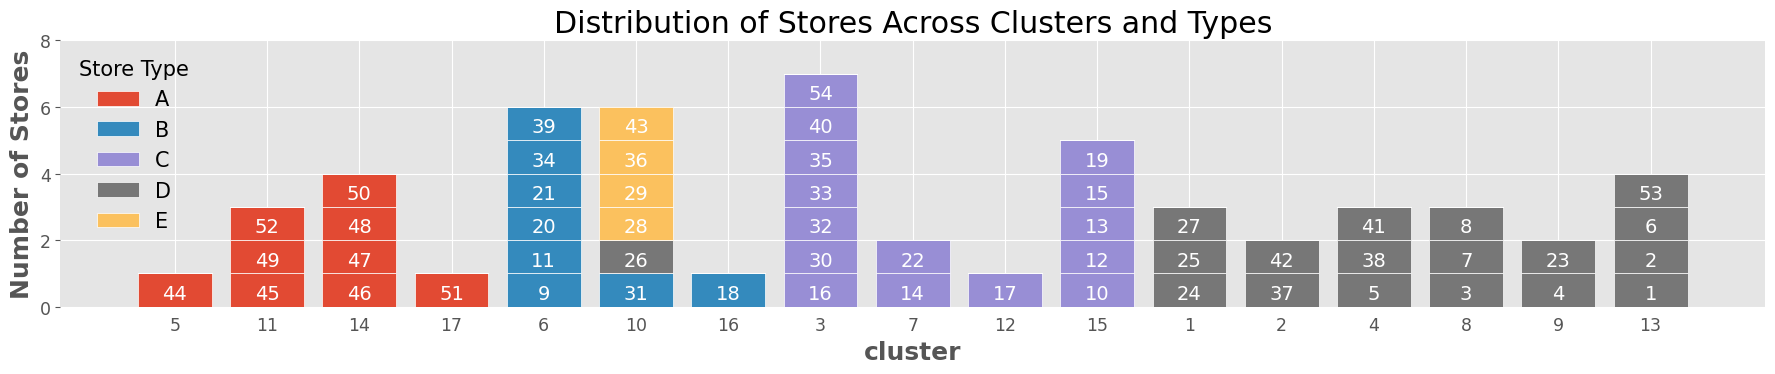

In [29]:
def plot_cluster_type_distribution(store):    
    cprint(
        "Static covariates: cluster, type",
        f"Number of unique store cluster: {store.cluster.nunique()}",
        f"Number of unique store type   : {store.type.nunique()}",
    )
    store = store.copy().sort_values(["type", "cluster"])
    cluster_list = store.cluster.unique().astype(str)
    type_list = store.type.sort_values().unique()
    bar_bottom = np.zeros(len(cluster_list))
    color_map = {s_type: c for s_type, c in zip(type_list, COLORS)}

    fig = plt.figure(figsize=(18, 4))
    
    for num in store.store_nbr.unique():
        curr_cluster, curr_type = store.loc[store.store_nbr.eq(num), ["cluster", "type"]].astype(str).values[0]
        cluster_ind = (cluster_list==curr_cluster).astype(int)
        plt.bar(
            x=cluster_list, height=cluster_ind,
            bottom=bar_bottom,
            zorder=2,
            color=color_map[curr_type],
            label=curr_type,
            edgecolor="white",
        )
        bar_bottom += cluster_ind
        running_total = bar_bottom[np.argmax(cluster_ind)]
        plt.text(
            x=curr_cluster, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Store Type")
    plt.xlabel("cluster")
    plt.ylabel("Number of Stores")
    plt.yticks(list(range(0, 9, 2)))
    plt.title("Distribution of Stores Across Clusters and Types")
    
    plt.tight_layout()
    plt.show()
    
plot_cluster_type_distribution(store)

### Finding: Some national holidays/events like Labor Day, Christmas, and the 2016 earthquake have larger impacts on sales.

Holidays/events are future covariates because the dates are usually known in advance. For simplicity, we will just use the term 'holiday' to denote both holidays and events throughout this notebook. As mentioned earlier, we need to compare sales between holiday and non-holiday periods. Looking at the boxplots below for each holiday, we note that **some have larger impacts on sales**. Examples are Labor Day (dia trabago), Christmas (navidad), and the 2016 earthquake (terremoto). We need to select the more useful ones to include in our models later.

Future covariate: national holidays
Number of unique national holidays: 15


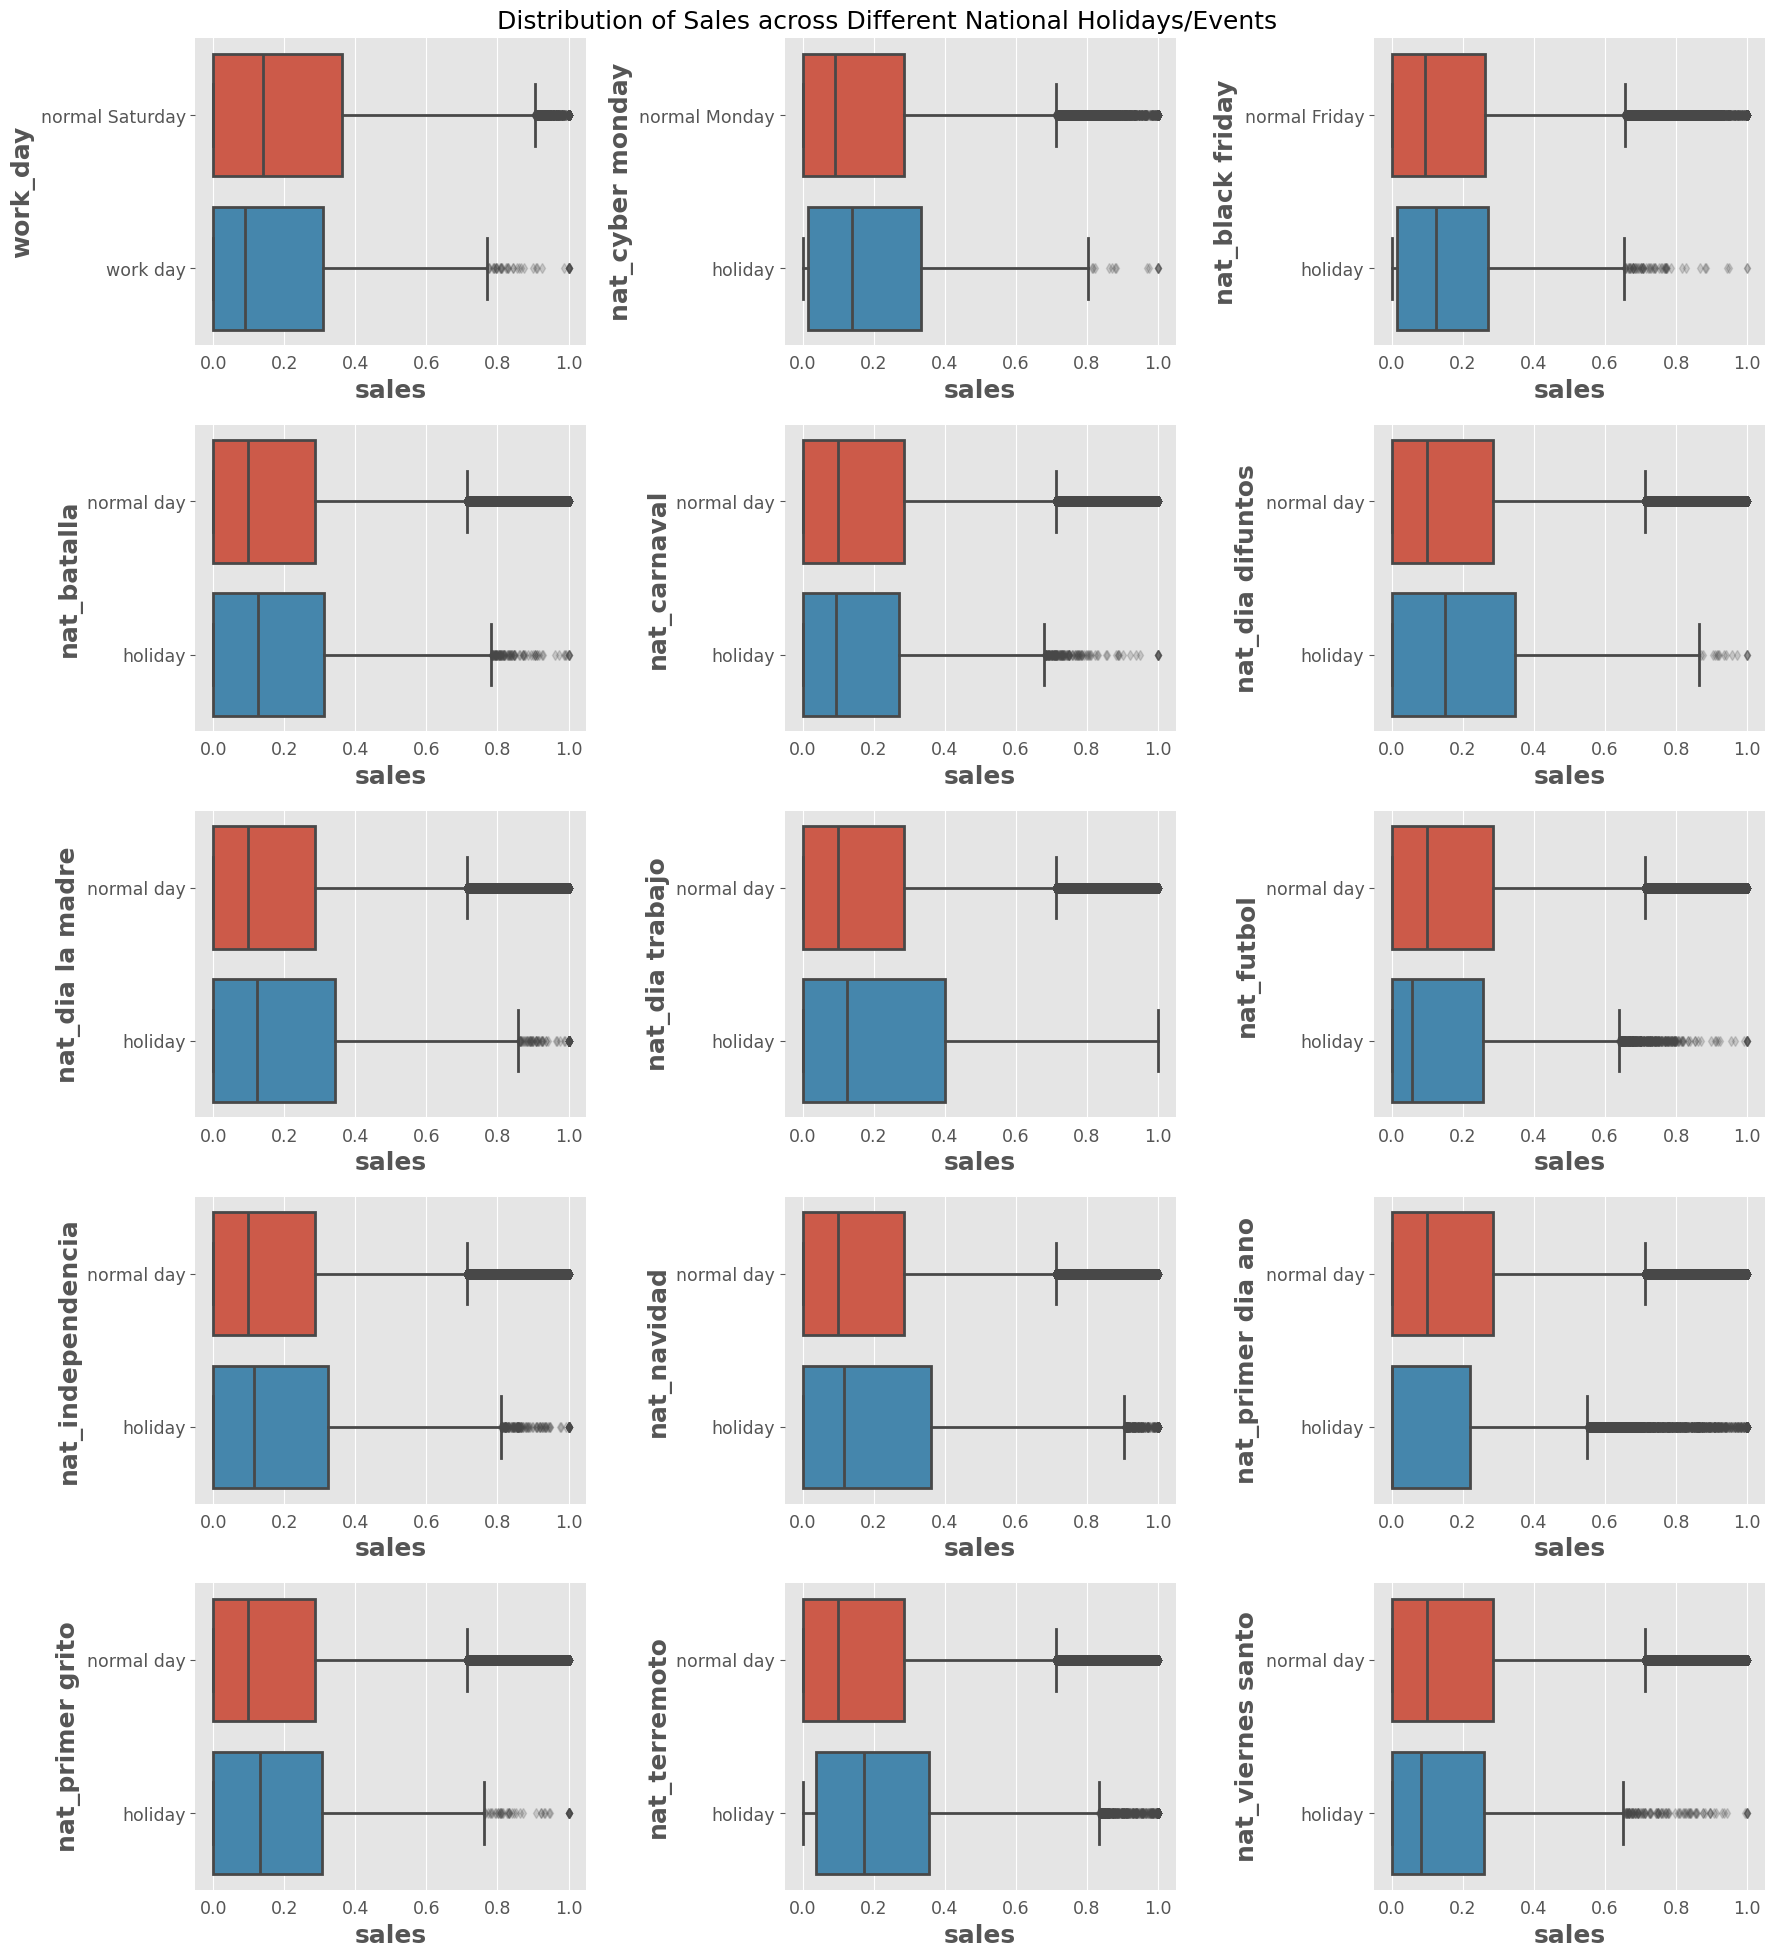

In [30]:
def plot_national_holiday_distribution():
    df = holiday_sales_merged.copy()    
    holiday_list = national_holidays.columns[1:]
    
    cprint(
        "Future covariate: national holidays",
        f"Number of unique national holidays: {len(holiday_list)+1}"
    )
    
    plot_kwargs = {
        "palette": COLORS[:2],
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
    
    fig = plt.figure(figsize=(18, 20))

    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(5)) & (df.no_holiday.eq(1))],
        y="work_day",
        x="sales",
        ax=fig.add_subplot(531),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Saturday", "work day"])

    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(0))],
        y="nat_cyber monday",
        x="sales",
        ax=fig.add_subplot(532),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Monday", "holiday"])
    
    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(4))],
        y="nat_black friday",
        x="sales",
        ax=fig.add_subplot(533),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Friday", "holiday"])
    
    for j, hol in enumerate(holiday_list.drop(["nat_cyber monday", "nat_black friday"])):
        sns.boxplot(
            data=df[(df[hol].eq(1)) | (df.no_holiday.eq(1))],
            y=hol,
            x="sales",
            ax=fig.add_subplot(5, 3, j+4),
            **plot_kwargs,
        )
        plt.yticks([0, 1], ["normal day", "holiday"])
        
    plt.suptitle("Distribution of Sales across Different National Holidays/Events")
    plt.tight_layout()
    plt.show()

plot_national_holiday_distribution()

### Finding: Regional and local holidays have smaller impacts on sales compared to national holidays.

Similarly, we investigate the effects of regional and local holidays using the boxplots below. Most boxplots look rather similar between the holiday and non-holiday periods, suggesting that regional and local holidays do not have as large of an impact on sales. This is reasonable because **national holidays are of a higher level of significance** and are thus more widely celebrated.

Future covariate: regional holidays
Total number of states                 : 16
Number of states with regional holidays: 4
Number of unique regional holidays     : 1


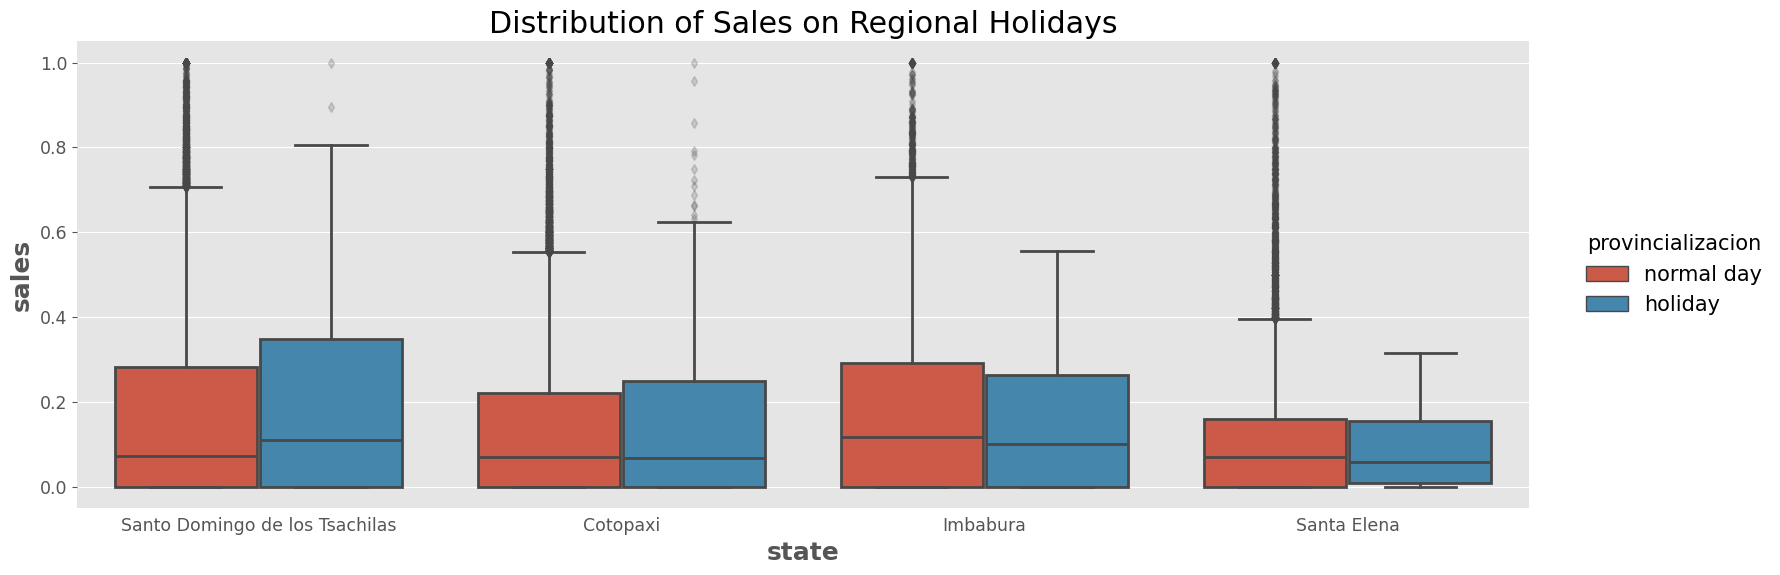

In [31]:
def plot_regional_holiday_distribution():
    df = holiday_sales_merged.copy()
    states_with_regional_holiday = regional_holidays.state.unique()
    df = df[df.state.isin(states_with_regional_holiday)]
    
    cprint(
        "Future covariate: regional holidays",
        f"Total number of states                 : {store.state.nunique()}",
        f"Number of states with regional holidays: {len(states_with_regional_holiday)}",
        "Number of unique regional holidays     : 1",
    )
    
    fig = plt.figure(figsize=(18, 6))

    sns.boxplot(
        data=df[(df.provincializacion.eq(1)) | (df.no_holiday.eq(1))],
        x="state",
        y="sales",
        hue="provincializacion",
        palette=COLORS[:2],
        linewidth=2,
        flierprops={"alpha": 0.2},
        ax=fig.add_subplot(111),
    )
    plt.title("Distribution of Sales on Regional Holidays")
    leg = plt.legend(loc="center", title="provincializacion", bbox_to_anchor=(1.1, 0.5))
    leg.texts[0].set_text("normal day")
    leg.texts[1].set_text("holiday")

    plt.tight_layout()
    plt.show()
    
plot_regional_holiday_distribution()

Future covariate: local holidays
Total number of cities              : 22
Number of cities with local holidays: 19
Number of unique local holidays     : 3


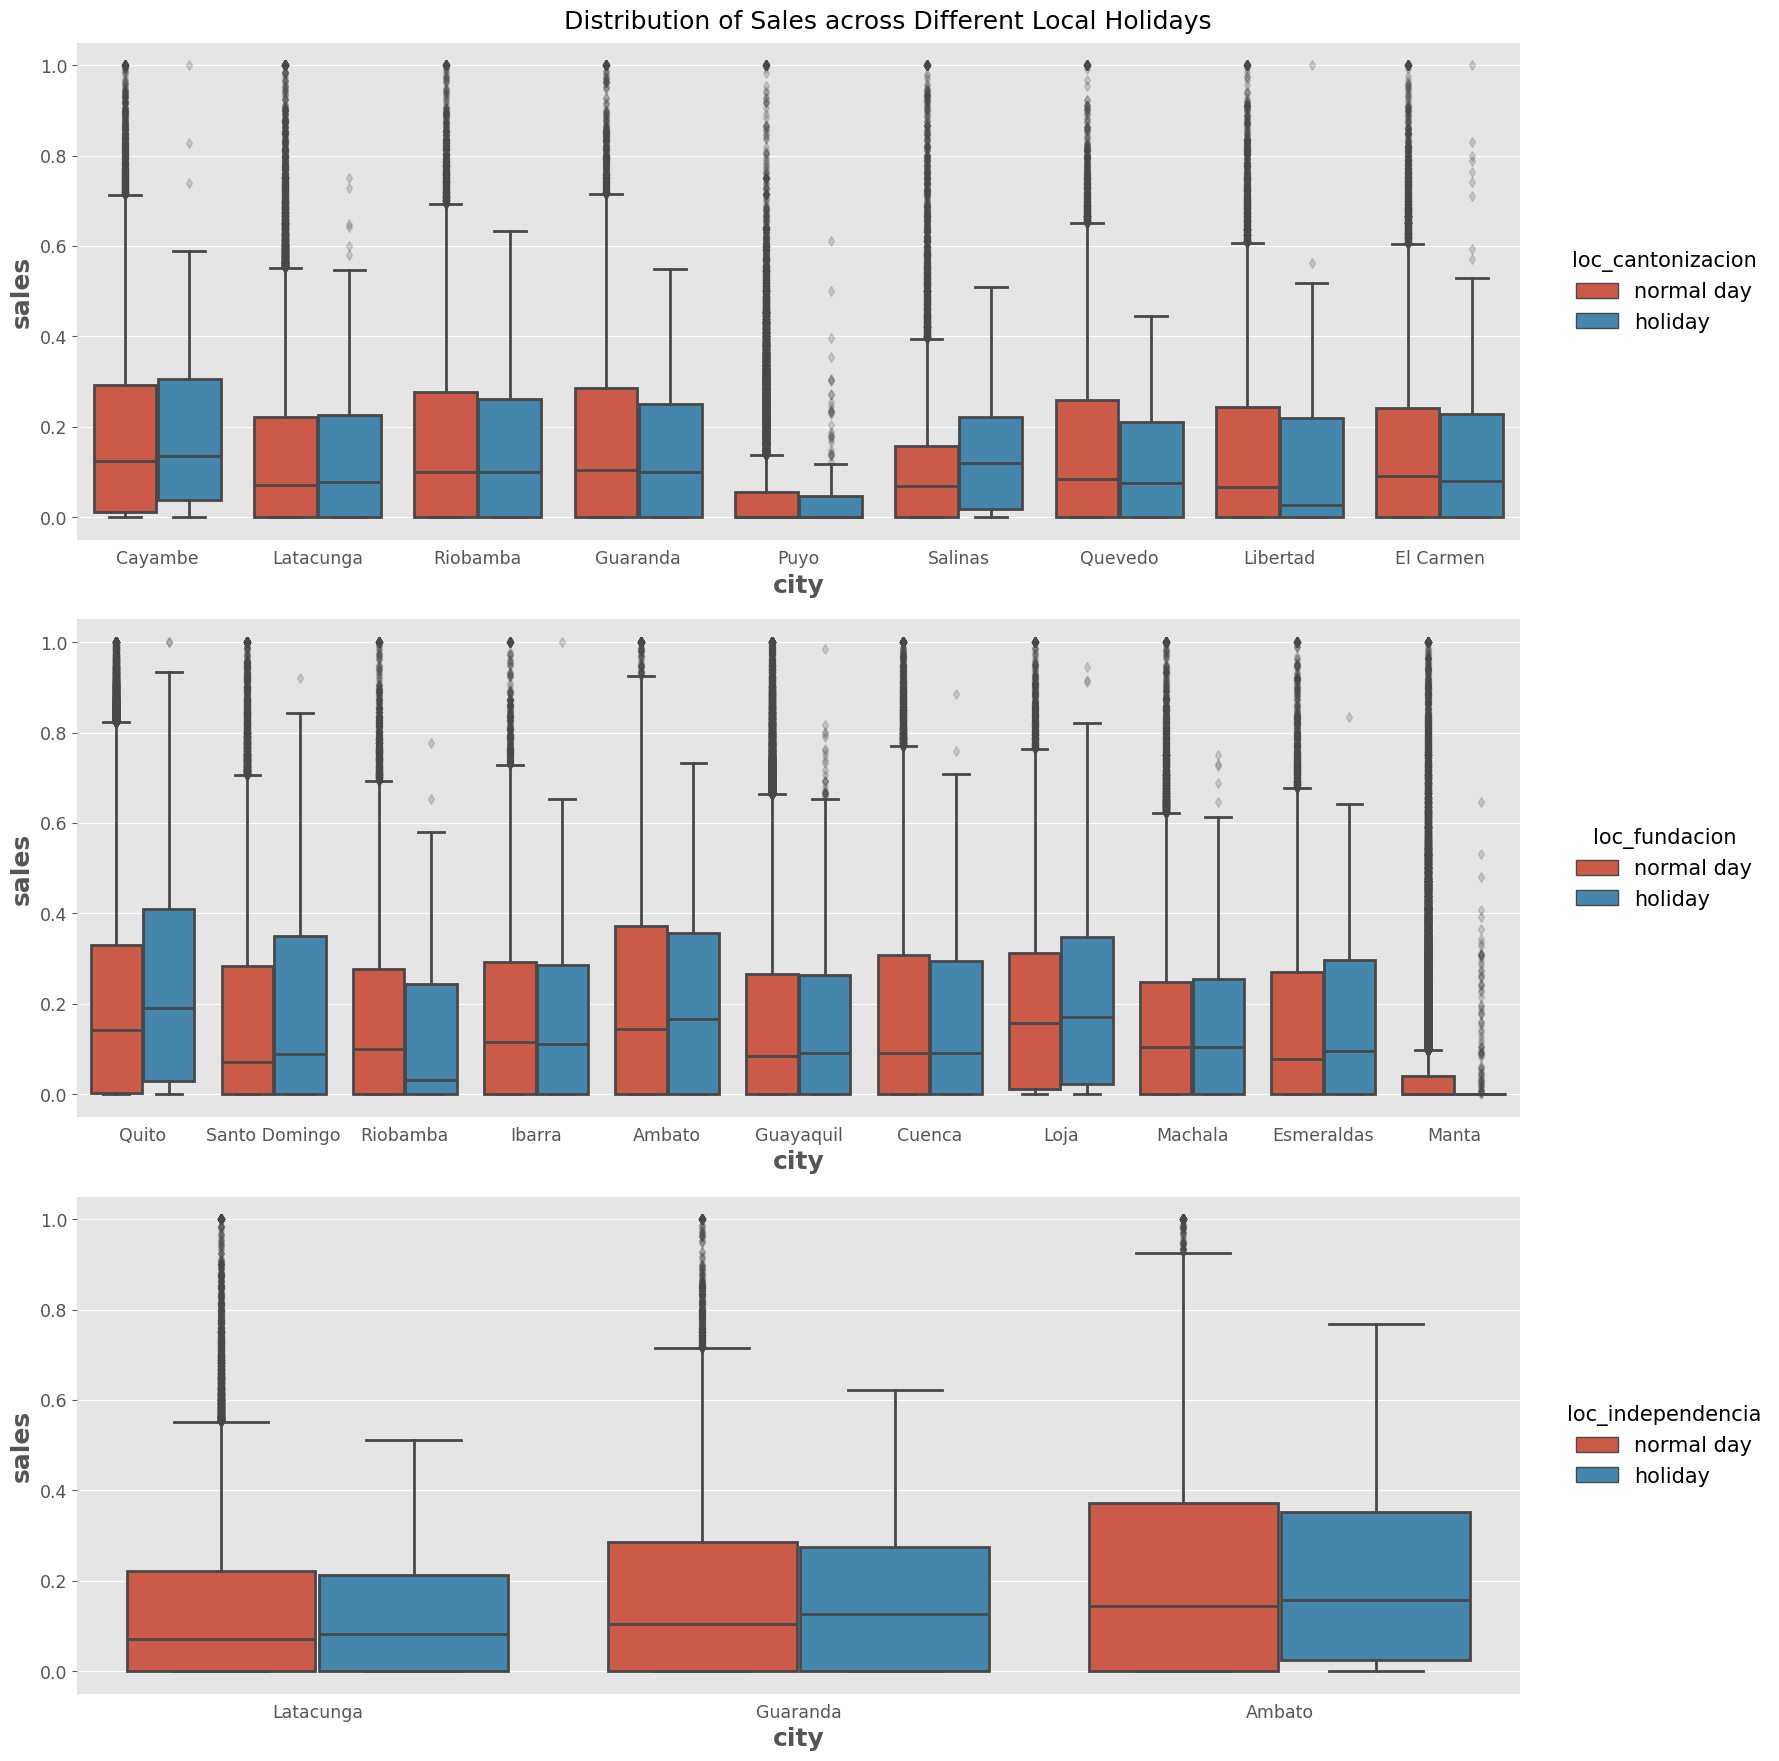

In [32]:
def plot_local_holiday_distribution():
    df = holiday_sales_merged.copy()
    holiday_list = local_holidays.columns[2:]
    
    cprint(
        "Future covariate: local holidays",
        f"Total number of cities              : {store.city.nunique()}",
        f"Number of cities with local holidays: {local_holidays.city.nunique()}",
        f"Number of unique local holidays     : {len(holiday_list)}",
    )
    
    fig = plt.figure(figsize=(18, 18))

    for j, hol in enumerate(holiday_list):
        tmp = df[df.city.isin(local_holidays[local_holidays[hol].eq(1)].city.unique())]
        sns.boxplot(
            data=tmp[(tmp[hol].eq(1)) | (tmp.no_holiday.eq(1))],
            x="city",
            y="sales",
            hue=hol,
            palette=COLORS[:2],
            linewidth=2,
            flierprops={"alpha": 0.2},
            ax=fig.add_subplot(3, 1, j+1),
        )
        leg = plt.legend(loc="center", title=hol, bbox_to_anchor=(1.1, 0.5))
        leg.texts[0].set_text("normal day")
        leg.texts[1].set_text("holiday")
        
    plt.suptitle("Distribution of Sales across Different Local Holidays")
    plt.tight_layout()
    plt.show()
    
plot_local_holiday_distribution()

### Finding: Sales patterns can be captured by date-related features.

Date-related features like the month and year of each data point are considered future covariates because they are fixed and thus known in advance. To prevent the influence of holiday effects, we make sure to filter the data to only include non-holiday periods. We attempt to look at the distribution of sales for each covariate using boxplots. Some covariates like the days of the year have really large numbers of categories (365-366 days in a year), so inspecting that many boxplots may not be plausible. For such cases, we just compute the average sales (across all the target series) for each time period. The following date-related features are created:
* `day`. With **paydays** being on the 15th and the last day of the month, we see that the sales tend to vary more around the same periods. In particular, this is more noticeable at the end/start of the month.
* `month`. While most of the boxplots look the same, the sales tend to vary greatly in December. This could be a **seasonal pattern** in which people prepare early for Christmas or New Year's Day.
* `year`. It is clear from the boxplots that the sales have a general **upward trend** across the year.
* `day_of_week`. Sales tend to be greater on weekends, which are non-working days for most people. It is reasonable to say that they have more time to visit the grocery stores, which translates to greater sales.
* `day_of_year` / `week_of_year`. The days of the year and weeks of the year give similar information to the months, but at **different levels of granularity**. To illustrate, while sales in the first week tend to be large, sales for the first day of the year is very small.
* `date_index`. The date index (index of the target series) gives similar information to the years, but at a **higher level of granularity**. There are some greater fluctuations in the first half of the time period.

Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index
day                     : paydays on the 15th and last day of the month
month                   : monthly seasonal patterns
year                    : general trends
day_of_week             : weekdays vs. weekends
day_of_year/week_of_year: different levels of granularity from month
date_index              : higher level of granularity than year


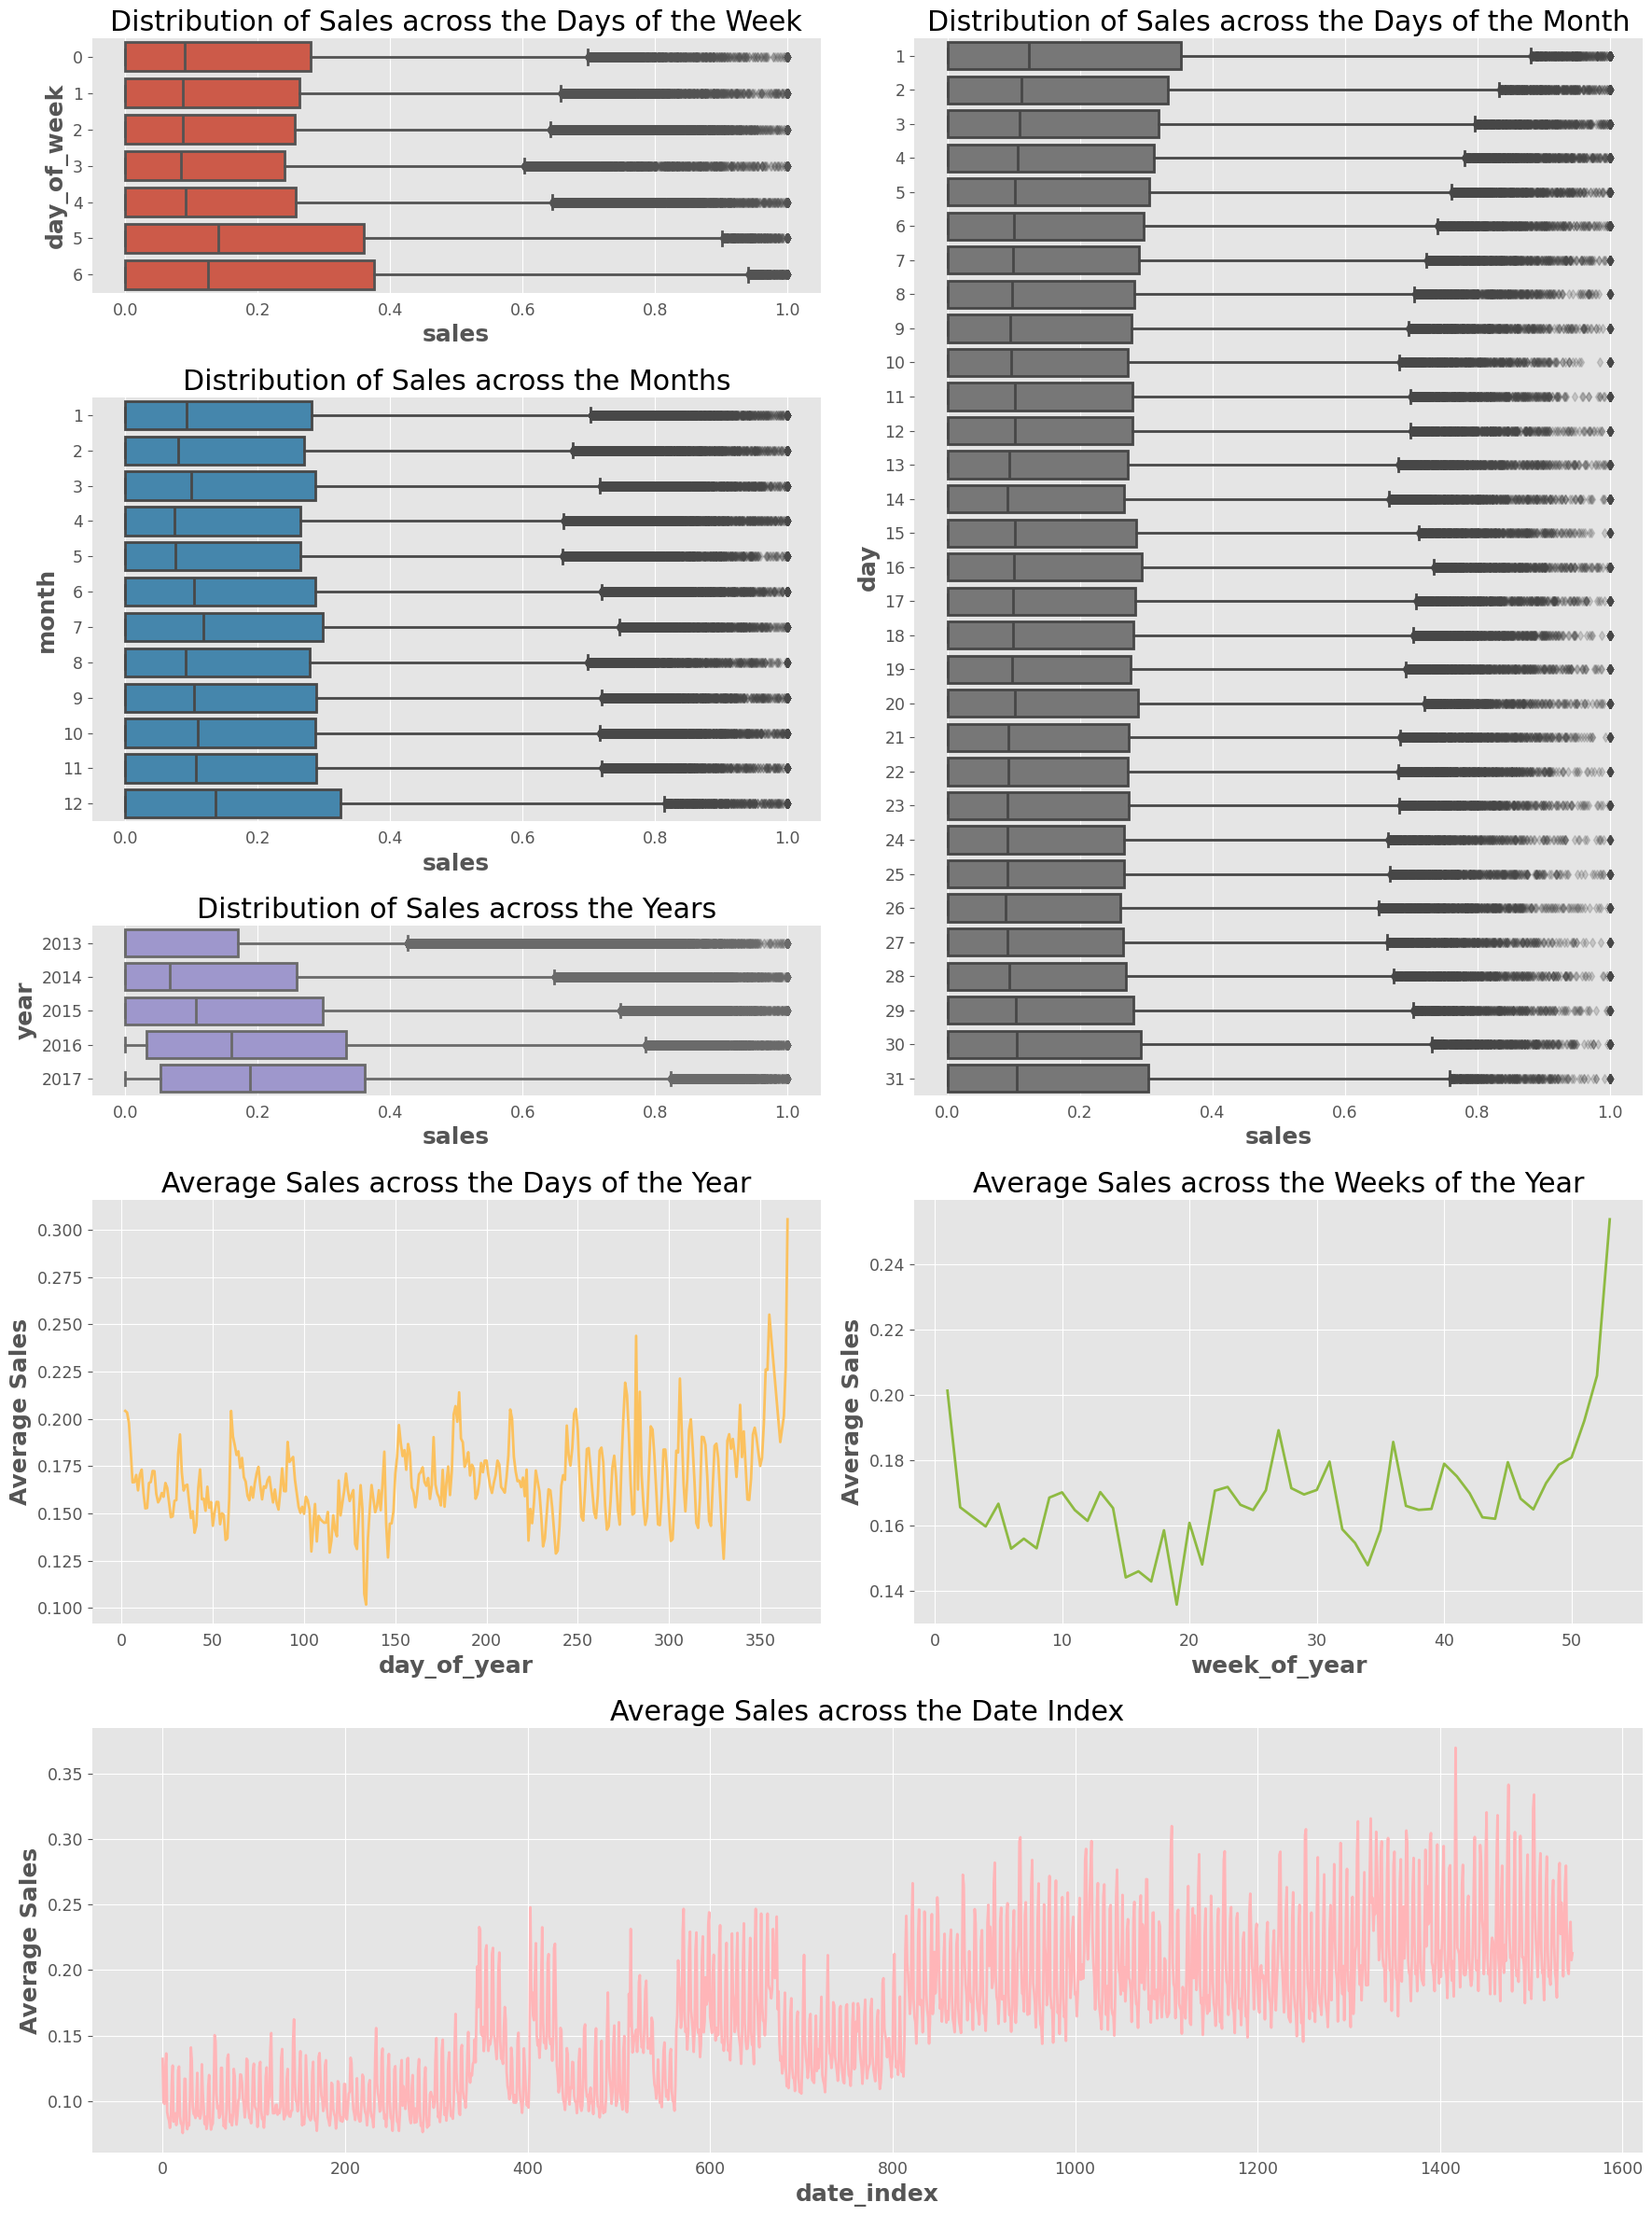

In [33]:
def plot_date_distribution():   
    df = holiday_sales_merged.copy().sort_values(["date", "store_nbr", "family"], ignore_index=True)
    df = df[df.no_holiday.eq(1)].reset_index(drop=True)
    df["day"] = df.date.dt.day
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["day_of_week"] = df.date.dt.dayofweek
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week.astype(int)
    df["date_index"] = df.date.factorize()[0]
    
    cprint(
        "Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index",
        "day                     : paydays on the 15th and last day of the month",
        "month                   : monthly seasonal patterns",
        "year                    : general trends",
        "day_of_week             : weekdays vs. weekends",
        "day_of_year/week_of_year: different levels of granularity from month",
        "date_index              : higher level of granularity than year",
    )
    
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
    
    fig = plt.figure(figsize=(18, 24))
    gs = fig.add_gridspec(5, 2, height_ratios=(3, 5, 2, 5, 5))
    
    sns.boxplot(
        data=df,
        y="day_of_week",
        x="sales",
        color=COLORS[0],
        ax=fig.add_subplot(gs[0, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Week")
    
    sns.boxplot(
        data=df,
        y="month",
        x="sales",
        color=COLORS[1],
        ax=fig.add_subplot(gs[1, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Months")
    
    sns.boxplot(
        data=df,
        y="year",
        x="sales",
        color=COLORS[2],
        ax=fig.add_subplot(gs[2, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Years")
    
    sns.boxplot(
        data=df,
        y="day",
        x="sales",
        color=COLORS[3],
        ax=fig.add_subplot(gs[:3, 1]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Month")
    
    sns.lineplot(
        data=df.groupby("day_of_year").sales.mean().reset_index(),
        x="day_of_year",
        y="sales",
        color=COLORS[4],
        ax=fig.add_subplot(gs[3, 0]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Days of the Year")
    
    sns.lineplot(
        data=df.groupby("week_of_year").sales.mean().reset_index(),
        x="week_of_year",
        y="sales",
        color=COLORS[5],
        ax=fig.add_subplot(gs[3, 1]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Weeks of the Year")
    
    sns.lineplot(
        data=df.groupby("date_index").sales.mean().reset_index(),
        x="date_index",
        y="sales",
        color=COLORS[6],
        ax=fig.add_subplot(gs[4, :]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Date Index")
    
    plt.tight_layout()
    plt.show()
    
plot_date_distribution()

---

# 3. Model Training

### Combining the datasets.

Now that we are done with our analysis, we proceed to train our models for forecasting. To prepare our data for training, we need to combine the relevant datasets and include the useful covariates as discussed previously. The steps taken are documented in the code below.

An additional step performed here is that for Christmas and New Year's Day, where most stores have zero sales (as they are likely closed), instead of filling the values with 0s, we temporarily set them to NaN and perform linear interpolation later. The reason for this is to **treat such days as regular holidays**, instead of having to include an additional variable to capture this unique behavior of store closure.

In [34]:
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,1,0.0
1,2013-01-01,2,0.0
2,2013-01-01,3,0.0
3,2013-01-01,4,0.0
4,2013-01-01,5,0.0


In [35]:
train.head()

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0
4,2013-01-01,1,BOOKS,4.0,0.0,0.0


In [36]:
# keep selected national holidays with larger impacts on sales
selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

# combine all the datasets
data = pd.concat(
    [train, test], axis=0, ignore_index=True,
).merge(
    transaction, on=["date", "store_nbr"], how="left",
).merge(
    oil, on="date", how="left",
).merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    keep_national_holidays, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# include date-related future covariates
data["day"] = data.date.dt.day
data["month"] = data.date.dt.month
data["year"] = data.date.dt.year
data["day_of_week"] = data.date.dt.dayofweek
data["day_of_year"] = data.date.dt.dayofyear
data["week_of_year"] = data.date.dt.isocalendar().week.astype(int)
data["date_index"] = data.date.factorize()[0] # sort by date above before computing this

# # to impute days with zero sales using linear interpolation later
zero_sales_dates = missing_dates + [f"{j}-01-01" for j in range(2013, 2018)]
data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan

# add prefixes for clarity
data.store_nbr = data.store_nbr.apply(lambda x: (f"store_nbr_{x}"))
data.cluster = data.cluster.apply(lambda x: (f"cluster_{x}"))
data.type = data.type.apply(lambda x: (f"type_{x}"))

# add prefixes to ensure no duplicate values between 'city' and 'state'
data.city = data.city.apply(lambda x: (f"city_{x.lower()}"))
data.state = data.state.apply(lambda x: (f"state_{x.lower()}"))

data.head()

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51029/1170038168.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan


,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0


### Defining the transformation pipelines.

From here on, we begin exploring the functionalities of the Darts library for forecasting. We define the transformation pipelines here, which includes:
* `MissingValuesFiller` to fill missing values like the NaN values we temporarily set previously. The default behavior is linear interpolation.
* `StaticCovariatesTransformer` to perform encoding/scaling of our static covariates. Our static covariates are all categorical, so we specify to perform one-hot encoding using `OneHotEncoder` from sklearn.
* `InvertibleMapper` to define a custom log transformer for our target series. Log transforming may help to stabilize our target series by reducing the magnitude of large values.
* `Scaler` to perform scaling for all our target series and covariates. The default behavior is min-max scaling.

In [37]:
def get_pipeline(static_covs_transform=False, log_transform=False):
    lst = []
    
    # fill missing values
    filler = MissingValuesFiller(n_jobs=-1)
    lst.append(filler)
    
    # specify transformation for static covariates
    if static_covs_transform:
        static_covs_transformer = StaticCovariatesTransformer(
            transformer_cat=OneHotEncoder(),
            n_jobs=-1,
        )
        lst.append(static_covs_transformer)

    # perform log transformation on sales
    if log_transform:
        log_transformer = InvertibleMapper(
            fn=np.log1p,
            inverse_fn=np.expm1,
            n_jobs=-1,
        )
        lst.append(log_transformer)

    # rescale time series
    scaler = Scaler()
    lst.append(scaler)

    # chain all transformations
    pipeline = Pipeline(lst)
    return pipeline

### Extracting the target series together with the static covariates.

Before we convert our data for forecasting with Darts, there is a need to identify the type of models to use. Traditional statistical models like ARIMA are focused on forecasting a single target series per model. As we have 1782 target series, building 1782 models can be computationally expensive. This is where the concept of global models comes in, allowing a single model to forecast multiple target series by making use of shared information. 

However, using a single model can make it challenging to represent all relevant variables accurately. A compromise would be to use multiple models, where each model forecasts a specific group of target series. It then makes sense for each group of target series to be similar in nature, allowing the models to capture the unique patterns within each group.

There are many ways to group the target series. From our findings above, the problems of zero sales and leading zeros could be related to the type of products sold, suggesting that **each product has its unique characteristics**. As such, a reasonable approach would be to have one model per product family, so we have a total of 33 models.

For the static covariates, we have identified the `city`, `state`, `cluster`, `type`, `store_nbr`, `family` columns. Since we are grouping the target series by product family, we can drop the `family` column.

In [38]:
def get_target_series(static_cols, log_transform=True):    
    target_dict = {}
    pipe_dict = {}
    id_dict = {}

    for fam in tqdm_notebook(data.family.unique(), desc="Extracting target series"):
        # filter data for each model
        df = data[(data.family.eq(fam)) & (data.date.le(train_end.strftime("%Y-%m-%d")))]
        
        # initialize transformation pipeline for target series
        pipe = get_pipeline(True, log_transform=log_transform)
        
        # extract target series together with static covariates
        target = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols="sales",
            group_cols="store_nbr",
            static_cols=static_cols,
        )

        # record identity of each target series
        target_id = [{"store_nbr": t.static_covariates.store_nbr[0], "family": fam} 
                     for t in target]
        id_dict[fam] = target_id
        
        # apply transformations
        target = pipe.fit_transform(target)
        target_dict[fam] = [t.astype(np.float32) for t in target]
        pipe_dict[fam] = pipe[2:]
        
    return target_dict, pipe_dict, id_dict

In [39]:
# list of static covariates excluding 'store_nbr'; 'store_nbr' is automatically extracted using 'group_cols'
static_cols = ["city", "state", "type", "cluster"]

target_dict, pipe_dict, id_dict = get_target_series(static_cols)

Extracting target series:   0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51029/4092426710.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_id = [{"store_nbr": t.static_covariates.store_nbr[0], "family": fam}
/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51029/4092426710.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_id = [{"store_nbr": t.static_covariates.store_nbr[0], "family": fam}
/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51029/4092426710.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

### Extracting the past and future covariates.

For past covariates, we only have the `transactions` column. For future covariates, we have the `oil`, `onpromotion` columns, the holiday columns, as well as the date-related columns. To improve our models, we can extract additional covariates by computing the moving averages of our time series data using `MovingAverageFilter`. Doing so helps to smooth out the noise and capture the underlying patterns more effectively.

\* *We follow the reference notebook to use moving averages of `oil` and `onpromotion` with window sizes 7, 28. The code below supports the computation of moving averages for only the past and future covariates. To include the moving averages of the target series `sales`, some edits are needed.*

In [40]:
def get_covariates(
    past_cols,
    future_cols,
    past_ma_cols=None,
    future_ma_cols=None,
    past_window_sizes=[7, 28],
    future_window_sizes=[7, 28],
):
    past_dict = {}
    future_dict = {}
    
    # initialize transformation pipeline for covariates
    covs_pipe = get_pipeline()

    for fam in tqdm_notebook(data.family.unique(), desc="Extracting covariates"):
        # filter data for each model
        df = data[data.family.eq(fam)]
        
        # extract past covariates
        past_covs = TimeSeries.from_group_dataframe(
            df=df[df.date.le(train_end.strftime("%Y-%m-%d"))],
            time_col="date",
            value_cols=past_cols,
            group_cols="store_nbr",
        )
        past_covs = [p.with_static_covariates(None) for p in past_covs]
        past_covs = covs_pipe.fit_transform(past_covs)
        if past_ma_cols is not None:
            for size in past_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in past_ma_cols]
                new_names = [f"{col}_ma{size}" for col in past_ma_cols]
                past_ma_covs = [
                    ma_filter.filter(p[past_ma_cols]).with_columns_renamed(old_names, new_names) 
                    for p in past_covs
                ]
                past_covs = [p.stack(p_ma) for p, p_ma in zip(past_covs, past_ma_covs)]
        
        past_dict[fam] = [p.astype(np.float32) for p in past_covs]

        # extract future covariates
        future_covs = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols=future_cols,
            group_cols="store_nbr",
        )
        future_covs = [f.with_static_covariates(None) for f in future_covs]
        future_covs = covs_pipe.fit_transform(future_covs)
        if future_ma_cols is not None:
            for size in future_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in future_ma_cols]
                new_names = [f"{col}_ma{size}" for col in future_ma_cols]
                future_ma_covs = [
                    ma_filter.filter(f[future_ma_cols]).with_columns_renamed(old_names, new_names) 
                    for f in future_covs
                ]
                future_covs = [f.stack(f_ma) for f, f_ma in zip(future_covs, future_ma_covs)]
        
        future_dict[fam] = [f.astype(np.float32) for f in future_covs]
            
    return past_dict, future_dict

In [41]:
# past covariates
past_cols = ["transactions"]

# future covariates
future_cols = [
    "oil", "onpromotion",
    "day", "month", "year", "day_of_week", "day_of_year", "week_of_year", "date_index",
    "work_day", *selected_holidays,
]

# additional past and future covariates from computing the moving averages
past_ma_cols = None
future_ma_cols = ["oil", "onpromotion"]

past_dict, future_dict = get_covariates(past_cols, future_cols, past_ma_cols, future_ma_cols)

Extracting covariates:   0%|          | 0/33 [00:00<?, ?it/s]

### Setting up the model trainer.

We are now done with extracting the time series data for forecasting with Darts. The complete list of covariates is shown below.

In [42]:
cprint(
    "List of all covariates:",
    "Static covariates:",
    static_cols + ["store_nbr"],
    "",
    "Past covariates:",
    past_dict["AUTOMOTIVE"][0].components.tolist(),
    "",
    "Future covariates:",
    future_dict["AUTOMOTIVE"][0].components.tolist(),
)

List of all covariates:
Static covariates:
['city', 'state', 'type', 'cluster', 'store_nbr']

Past covariates:
['transactions']

Future covariates:
['oil', 'onpromotion', 'day', 'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year', 'date_index', 'work_day', 'nat_terremoto', 'nat_navidad', 'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano', 'nat_futbol', 'nat_dia difuntos', 'oil_ma7', 'onpromotion_ma7', 'oil_ma28', 'onpromotion_ma28']


We now implement a model trainer to handle training, validation, and other related tasks. The trainer configuration is documented in the code below. 

Our forecasting horizon (`forecast_horizon`) is set to be 16 days, which is equal to the length of our test data. To evaluate our models, we will be performing time series cross-validation using a **rolling forecasting origin**. How this works is that we repeatedly build a training set expanding from the beginning of the target series. For each training set, the next 16 days (our forecasting horizon) will be our validation set. This process continues until we reach the end of the target series. The performance of the model is determined by the average RMSLE score across all the validation sets. A more detailed description of how this works can be found in this [online textbook](https://otexts.com/fpp3/tscv.html).

We have pointed out earlier that there are some target series with many trailing zeros, which could be due to consistent poor sales performance or product unavailability. As such, **generating zero forecasts** for such target series is a logical choice. We set a window size (`zero_fc_window`) that determines the number of previous days to check for zero sales in the configuration below.

\* *The reference notebooks generate zero forecasts for target series where the past 21 days are all zero sales.*

\** *To reduce computation time of this notebook, the configuration is set to perform the standard train-validation split for model evaluation.*

In [43]:
TRAINER_CONFIG = {
    # the time series data previously extracted
    "target_dict": target_dict,
    "pipe_dict": pipe_dict,
    "id_dict": id_dict,
    "past_dict": past_dict,
    "future_dict": future_dict,
    
    # time series cross-validation using a rolling forecasting origin
    "forecast_horizon": 16, # the length of the validation set
    "folds": 1, # the number of training sets (setting to 1 means the standard train-validation split)
    
    # the number of previous days to check for zero sales; if all are zero, generate zero forecasts
    "zero_fc_window": 21,
    
    # specify the covariates in a list to include in the model
    # set to None to not use any, and set to 'keep_all' to include everything
    "static_covs": "keep_all", # specify from ['city', 'state', 'cluster', 'type', 'store_nbr'], will extract all one-hot encoded columns
    "past_covs": "keep_all",
    "future_covs": "keep_all",
}

In [50]:
class Trainer:
    def __init__(
        self,
        target_dict,
        pipe_dict,
        id_dict,
        past_dict,
        future_dict,
        forecast_horizon,
        folds,
        zero_fc_window,
        static_covs=None,
        past_covs=None,
        future_covs=None,
    ):
        self.target_dict = target_dict.copy()
        self.pipe_dict = pipe_dict.copy()
        self.id_dict = id_dict.copy()
        self.past_dict = past_dict.copy()
        self.future_dict = future_dict.copy()
        self.forecast_horizon = forecast_horizon
        self.folds = folds
        self.zero_fc_window = zero_fc_window
        self.static_covs = static_covs
        self.past_covs = past_covs
        self.future_covs = future_covs
        
        # set up time series data
        self.setup()
    
    def setup(self):
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Setting up"):
            # keep the specified static covariates
            if self.static_covs != "keep_all":
                if self.static_covs is not None:
                    target = self.target_dict[fam]
                    keep_static = [col for col in target[0].static_covariates.columns if col.startswith(tuple(self.static_covs))]
                    static_covs_df = [t.static_covariates[keep_static] for t in target]
                    self.target_dict[fam] = [t.with_static_covariates(d) for t, d in zip(target, static_covs_df)]
                else:
                    self.target_dict[fam] = [t.with_static_covariates(None) for t in target]
            
            # keep the specified past covariates
            if self.past_covs != "keep_all":
                if self.past_covs is not None:
                    self.past_dict[fam] = [p[self.past_covs] for p in self.past_dict[fam]]
                else:
                    self.past_dict[fam] = None
                
            # keep the specified future covariates
            if self.future_covs != "keep_all":
                if self.future_covs is not None:
                    self.future_dict[fam] = [p[self.future_covs] for p in self.future_dict[fam]]
                else:
                    self.future_dict[fam] = None
    
    def clip(self, array):
        return np.clip(array, a_min=0., a_max=None)
    
    def train_valid_split(self, target, length):
        train = [t[:-length] for t in target]
        valid_end_idx = -length + self.forecast_horizon
        if valid_end_idx >= 0:
            valid_end_idx = None
        valid = [t[-length:valid_end_idx] for t in target]
        
        return train, valid
    
    def get_models(self, model_names, model_configs):
        models = {
            "lr": LinearRegressionModel,
            "lgbm": LightGBMModel,
            "cat": CatBoostModel,
            "xgb": XGBModel,
        }
        assert isinstance(model_names, list) and isinstance(model_configs, list),\
        "Both the model names and model configurations must be specified in lists."
        assert all(name in models for name in model_names),\
        f"Model names '{model_names}' not recognized."
        assert len(model_names) == len(model_configs),\
        "The number of model names and the number of model configurations do not match."
        
        if "xgb" in model_names:
            xgb_idx = np.where(np.array(model_names)=="xgb")[0]
            for idx in xgb_idx:
                # change to histogram-based method for XGBoost to get faster training time
                model_configs[idx] = {"tree_method": "hist", **model_configs[idx]}
        
        return [models[name](**model_configs[j]) for j, name in enumerate(model_names)]
    
    def generate_forecasts(self, models, train, pipe, past_covs, future_covs, drop_before):
        if drop_before is not None:
            date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
            train = [t.drop_before(date) for t in train]
        inputs = {
            "series": train,
            "past_covariates": past_covs,
            "future_covariates": future_covs,
        }
        zero_pred = pd.DataFrame({
            "date": pd.date_range(train[0].end_time(), periods=self.forecast_horizon+1)[1:],
            "sales": np.zeros(self.forecast_horizon),
        })
        zero_pred = TimeSeries.from_dataframe(
            df=zero_pred,
            time_col="date",
            value_cols="sales",
        )
        
        pred_list = []
        ens_pred = [0 for _ in range(len(train))]
        
        for m in models:
            # fit training data to model
            m.fit(**inputs)

            # generate forecasts and apply inverse transformations
            pred = m.predict(n=self.forecast_horizon, **inputs)
            pred = pipe.inverse_transform(pred)

            # set zero forecasts for target series where the recent observations are 0s
            for j in range(len(train)):
                if train[j][-self.zero_fc_window:].values().sum() == 0:
                    pred[j] = zero_pred
            
            # clip negative forecasts to 0s
            pred = [p.map(self.clip) for p in pred]
            pred_list.append(pred)
            
            # ensemble averaging
            for j in range(len(ens_pred)):
                ens_pred[j] += pred[j] / len(models)

        return pred_list, ens_pred
    
    def metric(self, valid, pred):
        return rmsle(valid, pred)
    
    def validate(self, model_names, model_configs, drop_before=None):
        # helper value to align printed text below
        longest_len = len(max(self.target_dict.keys(), key=len))
        
        # store metric values for each model
        model_metrics_history = []
        ens_metric_history = []
        
        for fam in tqdm_notebook(self.target_dict, desc="Performing validation"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # record average metric value over all folds
            model_metrics = []
            ens_metric = 0
            
            for j in range(self.folds):    
                # perform train-validation split and apply transformations
                length = (self.folds - j) * self.forecast_horizon
                train, valid = self.train_valid_split(target, length)
                valid = pipe.inverse_transform(valid)

                # generate forecasts and compute metric
                models = self.get_models(model_names, model_configs)
                pred_list, ens_pred = self.generate_forecasts(models, train, pipe, past_covs, future_covs, drop_before)
                metric_list = [self.metric(valid, pred) / self.folds for pred in pred_list]
                model_metrics.append(metric_list)
                if len(models) > 1:
                    ens_metric_fold = self.metric(valid, ens_pred) / self.folds
                    ens_metric += ens_metric_fold
                
            # store final metric value for each model
            model_metrics = np.sum(model_metrics, axis=0)
            model_metrics_history.append(model_metrics)
            ens_metric_history.append(ens_metric)
            
            # print metric value for each family
            print(
                fam,
                " " * (longest_len - len(fam)),
                " | ",
                " - ".join([f"{model}: {metric:.5f}" for model, metric in zip(model_names, model_metrics)]),
                f" - ens: {ens_metric:.5f}" if len(models) > 1 else "",
                sep="",
            )
            
        # print overall metric value
        cprint(
            "Average RMSLE | "
            + " - ".join([f"{model}: {metric:.5f}" 
                          for model, metric in zip(model_names, np.mean(model_metrics_history, axis=0))])
            + (f" - ens: {np.mean(ens_metric_history):.5f}" if len(models) > 1 else ""),
        )
        
    def ensemble_predict(self, model_names, model_configs, drop_before=None):        
        forecasts = []
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Generating forecasts"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            target_id = self.id_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # generate forecasts
            models = self.get_models(model_names, model_configs)
            pred_list, ens_pred = self.generate_forecasts(models, target, pipe, past_covs, future_covs, drop_before)
            ens_pred = [p.pd_dataframe().assign(**i) for p, i in zip(ens_pred, target_id)]
            ens_pred = pd.concat(ens_pred, axis=0)
            forecasts.append(ens_pred)
            
        # combine all forecasts into one dataframe
        forecasts = pd.concat(forecasts, axis=0)
        forecasts = forecasts.rename_axis(None, axis=1).reset_index(names="date")
        
        return forecasts

In [51]:
# initialize model trainer
trainer = Trainer(**TRAINER_CONFIG)

Setting up:   0%|          | 0/33 [00:00<?, ?it/s]

### Baseline: Linear Regression.

We use linear regression as the baseline model. The model configuration is documented below.

A thing to note here is that `output_chunk_length` refers to the number of days ahead that the model is predicting given today's input data. If this is set to be equal to the `forecast_horizon` of 16 days, we are doing a single-shot prediction. On the other hand, if we set it to only predict 1 day ahead, the model will make predictions autoregressively. Setting an appropriate value for this requires experimentation, but for simplicity we just set it to predict 1 day ahead.

Since we are only predicting 1 day ahead, this restricts the number of lags that can be used for the past covariates. For example, our past covariates are only known up till 15 August 2017 (the last day of the training data). To generate the forecast for 31 August 2017 (the last day of the test data), the most recent past covariates that can be used fall on 15 August 2017. As such, to account for this difference, we **can only use the past covariates starting from the 16th lag**.

On the other hand, our future covariates are known up till 31 August 2017. To generate the forecast for 31 August 2017 (the last day of the test data), the latest future covariates that can be used fall on 31 August 2017 as well. This means that we **can only use future covariates up till the point of forecasting**.

\* *The values in the model configuration are taken from the reference notebooks.*

In [52]:
BASE_CONFIG = {
    "random_state": 0,
    
    # the number of lag values of the target series
    "lags": 63,
    
    # the number of lag values of the past covariates
    "lags_past_covariates": list(range(-16, -23, -1)) if TRAINER_CONFIG["past_covs"] is not None else None,
    
    # the number of (past, future-1) lag values of the future covariates
    "lags_future_covariates": (14, 1) if TRAINER_CONFIG["future_covs"] is not None else None,
    
    # the number of days ahead that the model is forecasting given today's input data
    "output_chunk_length": 1,
}

Before validating our models, there is an additional parameter to specify, `drop_before`. This parameter refers to a specific date, where all data points before it are excluded. With a large training data of 1782 target series, reducing the number of data points can be helpful to increase the speed of model training. 

Moreover, there could be [change points](https://en.wikipedia.org/wiki/Change_detection) in our time series data such that the patterns are changing over time. Some evidence to support this would be the great fluctuations in the count of zero sales between 2014 and 2015, which are not observed in other time periods. Also, there are zero promotion values up till early 2014. These findings suggest that there could be structural changes in that time period. As such, using the entire data without accounting for such changes may break our models. The **recent data may be more reliable** for forecasting compared to the older data. This requires some experimentation.

In [53]:
# 'lr' for linear regression
# trainer.validate(["lr"], [BASE_CONFIG], drop_before="2015-01-01")

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


TypeError: unsupported operand type(s) for /: 'list' and 'int'

### LightGBM.

We now use gradient-boosting decision tree (GBDT) models for actual forecasting. Some state-of-the-art options include LightGBM, XGBoost and CatBoost. We only focus on LightGBM because it appears to have faster training time. Additional hyperparameters can be specified but for simplicity, we use the default values. To stabilize performance, we perform ensemble averaging by training multiple models and aggregating the forecasts through averaging. This helps to average out the errors.

\* *We adopt the approach taken in the reference notebook to use different numbers of lags of the target series for each model.*

In [55]:
GBDT_CONFIG1 = {
    **BASE_CONFIG,
    
    # the additional hyperparameters to be specified
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 6,
    
}

GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 365

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 730

To compute the ensemble average, we specify a list of models and their corresponding configurations to the trainer.

In [56]:
# 'lgbm' for LightGBM, 'xgb' for XGBoost, 'cat' for CatBoost
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm"]
ENS_CONFIGS = [GBDT_CONFIG1, GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4]

trainer.validate(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43638
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.506933


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29410
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.502433


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120812
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.520243


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209593
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.539387


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


TypeError: unsupported operand type(s) for /: 'list' and 'int'

---

# 4. Submission

### Generating forecasts for the test data.

For submission, we train one ensemble model on the entire training data and another ensemble model on a subset of the training data before taking the average. The RMSLE scores on the public leaderboard are as follows:
* Ensemble model trained on the entire data: 0.38073
* Ensemble model trained on a subset of the data: 0.38076
* Average of both ensemble models: 0.37984

It seems that training the ensemble model on just a subset of the data (from 2015 onwards) yields similar performance to the one trained on the entire data, but has faster training speed. Taking the average of both ensemble models results in an even better RMSLE score. This shows that training on different subsets of the data and then combining the predictions can potentially make the results more robust.

In [ ]:
# generate forecasts for model trained on the entire data
predictions1 = trainer.ensemble_predict(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
)

# generate forecasts for model trained on a subset of the data
predictions2 = trainer.ensemble_predict(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

In [ ]:
# compute the average of the ensemble models
final_predictions = predictions1.merge(
    predictions2, on=["date", "store_nbr", "family"], how="left",
)
final_predictions["sales"] = final_predictions[["sales_x", "sales_y"]].mean(axis=1)
final_predictions = final_predictions.drop(columns=["sales_x", "sales_y"])

final_predictions.head()

### Preparing for the submission.

In [ ]:
def prepare_submission(predictions):
    predictions = predictions.copy()
    
    # process column values for merging
    predictions.store_nbr = predictions.store_nbr.replace(
        "store_nbr_", "", regex=True,
    ).astype(int)
     
    # match with corresponding 'id'
    submission = test.merge(
        predictions, on=["date", "store_nbr", "family"], how="left",
    )[["id", "sales"]]
    
    return submission

In [ ]:
submission = prepare_submission(final_predictions)

submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)

---